# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

car_id            model  car_type fuel_type  car_rating  \
989   p-1229769J  Renault Sandero  standart    petrol        5.56   
1679  Z-1064749o        Kia Rio X   economy    petrol        4.34   
498   t18819186j    Smart ForFour   economy    petrol        2.04   
1216  D-6990841m     Kia Sportage  standart    petrol        4.14   
697   C20191765o        Kia Rio X   economy    petrol        3.62   

      year_to_start  riders  year_to_work  target_reg     target_class  
989            2015   75476          2014       35.29  engine_overheat  
1679           2011    2052          2020       39.94      wheel_shake  
498            2017  128730          2018       65.26  engine_ignition  
1216           2013   40420          2019       35.23        break_bug  
697            2015   93392          2017       61.33  engine_ignition

- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

In [3]:
car_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_reg     2337 non-null   float64
 9   target_class   2337 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 182.7+ KB


In [4]:
car_train['car_id'].nunique()

2337

### Информация про поездки

In [5]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

user_id      car_id ride_id   ride_date  rating  ride_duration  \
77764   b75399459I  F14063148j     F1g  2020-03-25    1.63             30   
632686  R18573777h  s19224549D     H1N  2020-01-13    5.00             52   
37135   b25967863v  C-6633868m     S1G  2020-02-09    3.81             35   
534533  X52841114g  l34820395K     P1w  2020-01-03    0.10             17   
436104  C72356995g  e64842741d     N1P  2020-02-02    5.31             79   

        ride_cost  speed_avg   speed_max  stop_times     distance  refueling  \
77764         416         85  128.878290           0  2207.053393          0   
632686        515         51   72.000000           1  2597.416920          0   
37135         413         61   85.375935           0  2159.186653          0   
534533        198         47   76.000000           0   720.851377          0   
436104        628         47   61.000000           1  1725.115162          0   

        user_ride_quality  deviation_normal  
77764            2.664902            14.367  
632686          -1.171014            26.479  
37135           -4.848135            19.320  
534533           2.522757            30.667  
436104          -9.942156           -48.055

- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

In [6]:
# Информация о датафрейме. 739_500 строк, 14 колонок, пропущенные значения есть в колонках speed_max и user_ride_quality
rides_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739500 entries, 0 to 739499
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            739500 non-null  object 
 1   car_id             739500 non-null  object 
 2   ride_id            739500 non-null  object 
 3   ride_date          739500 non-null  object 
 4   rating             739500 non-null  float64
 5   ride_duration      739500 non-null  int64  
 6   ride_cost          739500 non-null  int64  
 7   speed_avg          739500 non-null  int64  
 8   speed_max          736139 non-null  float64
 9   stop_times         739500 non-null  int64  
 10  distance           739500 non-null  float64
 11  refueling          739500 non-null  int64  
 12  user_ride_quality  736872 non-null  float64
 13  deviation_normal   739500 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 79.0+ MB


In [7]:
# Дубликатов нет
rides_info.duplicated().sum()

0

In [8]:
rides_info.duplicated(subset=['user_id', 'car_id', 'ride_id']).sum()

0

In [9]:
rides_info['user_id'].nunique()

15153

In [10]:
rides_info['ride_id'].nunique()

2704

In [11]:
rides_info['car_id'].nunique()

4250

### Информация про водителей

In [12]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

age  user_rating  user_rides  user_time_accident     user_id  sex  \
287     25          8.3        1872                 6.0  c15509256P    1   
9609    22          8.8        1590                 5.0  r10712510H    1   
13632   23          8.0        1177                13.0  m70438466c    1   
13027   18          8.4         331                 NaN  G11960641i    1   
1399    59          7.8        1120                 4.0  N19021616c    0   

      first_ride_date  
287         2018-4-12  
9609        2018-6-24  
13632      2018-10-13  
13027        2020-5-9  
1399        2019-1-23

- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

In [13]:
driver_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15153 non-null  int64  
 1   user_rating         15153 non-null  float64
 2   user_rides          15153 non-null  int64  
 3   user_time_accident  14182 non-null  float64
 4   user_id             15153 non-null  object 
 5   sex                 15153 non-null  int64  
 6   first_ride_date     15153 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 828.8+ KB


In [14]:
driver_info['user_id'].nunique()

15153

In [15]:
driver_info[driver_info['user_id'] == 'D10082142F']

age  user_rating  user_rides  user_time_accident     user_id  sex  \
4249   23          8.5           0                 NaN  D10082142F    1   

     first_ride_date  
4249       2020-2-12

In [16]:
driver_info.describe()

age   user_rating    user_rides  user_time_accident  \
count  15153.000000  15153.000000  15153.000000        14182.000000   
mean      33.581073      8.109345    871.015442           10.129601   
std        9.919271      0.668246    573.512378            8.867482   
min       18.000000      5.800000      0.000000            0.000000   
25%       25.000000      7.700000    421.000000            4.000000   
50%       33.000000      8.100000    876.000000            9.000000   
75%       41.000000      8.600000   1145.000000           14.000000   
max       63.000000     10.000000   3316.000000           86.000000   

                sex  
count  15153.000000  
mean       0.499967  
std        0.500016  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        1.000000  
max        1.000000

In [17]:
driver_info['user_time_accident'] = driver_info['user_time_accident'].fillna(0)

In [18]:
driver_info[driver_info['user_time_accident'].isnull()]

Empty DataFrame
Columns: [age, user_rating, user_rides, user_time_accident, user_id, sex, first_ride_date]
Index: []

### Информация про ремонт машин

In [19]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

car_id worker_id         fix_date     work_type  destroy_degree  \
124630  i47017449U        OZ  2020-2-12 13:21  refuel_check             1.0   
54544   x13838636N        IX  2019-3-15 19:55     reparking             1.0   
133392  J-1137633W        NN   2020-4-11 1:28     reparking             1.0   
10496   p-1518592V        HM  2019-5-13 14:29        refuel             1.0   
898     I96387228J        ZS    2018-4-1 4:15     reparking             1.0   

        work_duration  
124630             32  
54544              26  
133392             20  
10496              35  
898                24

- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

In [20]:
fix_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   car_id          146000 non-null  object 
 1   worker_id       146000 non-null  object 
 2   fix_date        146000 non-null  object 
 3   work_type       146000 non-null  object 
 4   destroy_degree  146000 non-null  float64
 5   work_duration   146000 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [21]:
fix_info['car_id'].nunique()

4250

In [22]:
fix_info['worker_id'].nunique()

546

In [23]:
# Дубликатов нет
fix_info.duplicated().sum()

0

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [24]:
# # Пример расчета одного признака
# rides_info.groupby('car_id', as_index=False).agg(
#     mean_rating = ('rating', 'mean'),
#     # ... еще признаки
# )

# df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# YOUR CODE HERE

### Идеи для новых признаков

- Для riders_info
1. Средняя стоимость одной ед. времени поездки = mean(ride_cost/ride_duration)
2. Значение точки старта для user_ride_quality
3. Средняя скорость
4. Общее количество остановок

- Для driver_info
1. Средний возраст водителей на машину
2. Средний рейтинг водителей на машину
3. Медиана числа инцидентов водителей на машину
4. Стандартное отклонение числа инцидентов водителей на машину
5. Медиана числа инцидентов на поездку водителя на машину

- Для fix_info
1. Максимальная длительность ремонта
2. Средняя длительность ремонта
3. Стандартное отклонение степени износа машины
4. Уникальное кол-во типов работ для машины
5. Часто встречающийся тип работ для машины

* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [25]:
# Коэффициент инцидентности, кол-во инцидентов на одну поезду водителя в таблице driver_info
driver_info['accident_per_ride'] = driver_info['user_time_accident']/driver_info['user_rides']

In [26]:
driver_info['accident_per_ride'] = driver_info['accident_per_ride'].fillna(0)

In [27]:
# Соединение таблиц с поездками и водителями
rides_driver = rides_info.merge(driver_info, on='user_id', how='left')
rides_driver

user_id      car_id ride_id   ride_date  rating  ride_duration  \
0       o52317055h  A-1049127W     b1v  2020-01-01    4.95             21   
1       H41298704y  A-1049127W     T1U  2020-01-01    6.91              8   
2       v88009926E  A-1049127W     g1p  2020-01-02    6.01             20   
3       t14229455i  A-1049127W     S1c  2020-01-02    0.26             19   
4       W17067612E  A-1049127W     X1b  2020-01-03    1.21             56   
...            ...         ...     ...         ...     ...            ...   
739495  I15732675M  z91796444U     m1z  2020-03-30    7.42            164   
739496  r51579957X  z91796444U     t1P  2020-03-30    4.19             26   
739497  l15212727I  z91796444U     z1A  2020-03-31    3.40             23   
739498  Z78949958q  z91796444U     w1R  2020-04-01    9.02              5   
739499  T14594979g  z91796444U     k1R  2020-04-01    5.96             29   

        ride_cost  speed_avg   speed_max  stop_times  ...  refueling  \
0             268         36  113.548538           0  ...          0   
1              59         36   93.000000           1  ...          0   
2             315         61   81.959675           0  ...          0   
3             205         32  128.000000           0  ...          0   
4             554         38   90.000000           1  ...          0   
...           ...        ...         ...         ...  ...        ...   
739495       2290         49   54.586302           0  ...          0   
739496        412         46   73.000000           0  ...          0   
739497        178         37   71.000000           1  ...          0   
739498         75         48   87.000000           1  ...          0   
739499        344         45   55.000000           2  ...          0   

        user_ride_quality  deviation_normal  age  user_rating  user_rides  \
0                1.115260             2.909   18          8.0         228   
1                1.650465             4.133   40          7.0         992   
2                2.599112             2.461   32          7.7        1646   
3                3.216255             0.909   35          7.7        1899   
4                2.716550            -1.822   24          7.6         472   
...                   ...               ...  ...          ...         ...   
739495           6.137593           -39.752   39          7.3         817   
739496           6.703367           -38.480   33          8.0         357   
739497           6.255344           -45.080   18          7.6        1065   
739498           7.759949           -60.193   34          7.9         301   
739499                NaN           -50.835   21          7.0         193   

        user_time_accident  sex  first_ride_date accident_per_ride  
0                      9.0    1        2019-9-16          0.039474  
1                      9.0    0        2019-2-26          0.009073  
2                      3.0    1        2018-6-11          0.001823  
3                      8.0    0        2021-9-22          0.004213  
4                      1.0    1        2019-7-13          0.002119  
...                    ...  ...              ...               ...  
739495                 3.0    0        2019-4-13          0.003672  
739496                13.0    1        2020-5-15          0.036415  
739497                 8.0    1       2020-11-19          0.007512  
739498                 6.0    0        2019-8-26          0.019934  
739499                 0.0    1         2020-4-4          0.000000  

[739500 rows x 21 columns]

In [28]:
rides_driver.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 739500 entries, 0 to 739499
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             739500 non-null  object 
 1   car_id              739500 non-null  object 
 2   ride_id             739500 non-null  object 
 3   ride_date           739500 non-null  object 
 4   rating              739500 non-null  float64
 5   ride_duration       739500 non-null  int64  
 6   ride_cost           739500 non-null  int64  
 7   speed_avg           739500 non-null  int64  
 8   speed_max           736139 non-null  float64
 9   stop_times          739500 non-null  int64  
 10  distance            739500 non-null  float64
 11  refueling           739500 non-null  int64  
 12  user_ride_quality   736872 non-null  float64
 13  deviation_normal    739500 non-null  float64
 14  age                 739500 non-null  int64  
 15  user_rating         739500 non-nul

In [29]:
# Приведение даты к типу datetime
rides_driver['ride_date'] = pd.to_datetime(rides_driver['ride_date'])
rides_info['ride_date'] = pd.to_datetime(rides_info['ride_date'])

In [30]:
# Стоимость одной ед. времени поездки
rides_driver['cost_per_time'] = rides_driver['ride_cost']/rides_driver['ride_duration']

In [31]:
# Дополнительный признак точка старта для user_ride_quality для riders_info
rides_info_sorted = rides_info.sort_values(by=['car_id', 'ride_date'])
start_user_ride_quality = rides_info_sorted.groupby('car_id').first().reset_index()[['car_id', 'user_ride_quality']]
start_user_ride_quality.rename(columns={'user_ride_quality': 'start_user_ride_quality'}, inplace=True)
start_user_ride_quality

car_id  start_user_ride_quality
0     A-1049127W                 1.115260
1     A-1079539w                 1.393078
2     A-1162143G                -0.761940
3     A-1228282M                -0.218557
4     A-1339912r                -0.173667
...          ...                      ...
4245  z73688663a                 2.217938
4246  z73740510r                -1.338218
4247  z86911952C                 1.095659
4248  z91353693Z                 1.575370
4249  z91796444U                -1.457378

[4250 rows x 2 columns]

In [32]:
start_user_ride_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   car_id                   4250 non-null   object 
 1   start_user_ride_quality  4250 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.5+ KB


In [33]:
# Группировка данных по car_id с расчетом признаков для riders_info, driver_info 
car_rides_driver = rides_driver.groupby('car_id', as_index=False).agg(
    # 5 обязательных признаков для riders_info
    min_rating=('rating', 'min'), # минимальный рейтинг
    mean_rating=('rating', 'mean'), # средний рейтинг
    total_distance=('distance', 'sum'), # общее пройденное расстояние
    max_speed=('speed_max', 'max'), # максимальная скорость
    total_rides=('ride_id', 'count'), # общее количество поездок
    
    # Дополнительные признаки для riders_info
    mean_cost_per_time=('cost_per_time', 'mean'), # средняя стоимость одной ед. времени поездки
    avg_speed=('speed_avg', 'mean'), # средняя скорость
    total_stop_times=('stop_times', 'sum'),  # общее количество остановок
    deviation_normal_min_max_diff=('deviation_normal', lambda x: x.max() - x.min()), #разница между макс. и мин. значениями deviation_normal
    deviation_normal_mean=('deviation_normal', 'mean'), # среднее значение deviation_normal
    user_ride_quality_nans=('user_ride_quality', lambda x: x.isnull().sum()), # сумма пропусков для user_ride_quality
    
    # Признаки для driver_info
    avg_user_age=('age', 'mean'), # средний возраст водителей
    avg_user_rating=('user_rating', 'mean'), # средний рейтинг водителей 
    median_user_time_accident=('user_time_accident', 'median'), # медиана числа инцидентов водителей
    std_user_time_accident=('user_time_accident', 'std'), # стандартное отклонение числа инцидентов водителей
    median_user_accident_per_ride=('accident_per_ride', 'median') # медиана числа инцидентов на поездку водителей
)
car_rides_driver

car_id  min_rating  mean_rating  total_distance   max_speed  \
0     A-1049127W        0.10     4.255172    1.125753e+07  179.729652   
1     A-1079539w        0.10     4.088046    1.912765e+07  184.505566   
2     A-1162143G        0.10     4.662299    2.995194e+06  180.000000   
3     A-1228282M        0.10     4.225172    1.793685e+07  182.446070   
4     A-1339912r        0.10     4.690115    1.202552e+07  152.000000   
...          ...         ...          ...             ...         ...   
4245  z73688663a        0.10     4.808448    1.113943e+07  165.000000   
4246  z73740510r        0.28     4.699655    7.215961e+06  117.397405   
4247  z86911952C        0.00     4.430977    2.135104e+07  173.428116   
4248  z91353693Z        0.10     5.326092    1.614384e+07  106.089167   
4249  z91796444U        0.10     4.307471    7.453857e+06  108.653269   

      total_rides  mean_cost_per_time  avg_speed  total_stop_times  \
0             174           11.273095  49.459770               142   
1             174           11.684273  49.591954               144   
2             174           11.407817  43.448276               721   
3             174           11.150394  49.379310               132   
4             174           11.633544  44.149425               155   
...           ...                 ...        ...               ...   
4245          174           11.334100  45.367816               129   
4246          174           11.653506  43.770115               622   
4247          174           11.224255  47.155172               136   
4248          174           11.406435  44.264368               139   
4249          174           11.121589  44.275862               130   

      deviation_normal_min_max_diff  deviation_normal_mean  \
0                            31.688              -6.136672   
1                            74.349              47.443270   
2                            46.177              10.556425   
3                            64.898               9.810747   
4                            40.142              22.965937   
...                             ...                    ...   
4245                         67.991             -13.846075   
4246                         59.877               7.026477   
4247                         75.449             -25.382126   
4248                         60.076              -8.031167   
4249                         75.328             -33.506908   

      user_ride_quality_nans  avg_user_age  avg_user_rating  \
0                          0     33.666667         7.817816   
1                          0     32.344828         7.773563   
2                          0     34.241379         8.149425   
3                          0     33.609195         8.045402   
4                          0     33.948276         8.195402   
...                      ...           ...              ...   
4245                       0     32.327586         8.156322   
4246                       0     36.097701         8.096552   
4247                       0     33.195402         8.014368   
4248                       0     34.839080         8.024138   
4249                      12     33.143678         7.763218   

      median_user_time_accident  std_user_time_accident  \
0                           8.0                5.240163   
1                           8.0                4.837664   
2                           7.5               16.712697   
3                           8.0                5.156681   
4                           6.5               17.084064   
...                         ...                     ...   
4245                        5.0               16.207015   
4246                        3.0               13.246542   
4247                        7.0                4.972665   
4248                        7.0                4.561526   
4249                        9.0                4.730558   

      median_user_accident_per_ride  
0                          0.010191  
1    

In [34]:
# Соединение start_user_ride_quality с таблицей riders_driver
car_rides_driver = car_rides_driver.merge(start_user_ride_quality, on='car_id', how='left')

In [35]:
# Функция подсчета кол-ва уникальных значений
f_nunique = lambda x: x.nunique()
# Функции поиска моды для work_type (категориальной переменной)
first_mode = lambda x: x.value_counts().index[0]

In [36]:
# Группировка данных по car_id с расчетом признаков для fix_info
car_fix = fix_info.groupby('car_id', as_index=False).agg(
    # Признаки для fix_info
    work_duration_max=('work_duration', 'max'), # максимальная длительность ремонта
    work_duration_mean=('work_duration', 'mean'), # средняя длительность ремонта
    destroy_degree_std=('destroy_degree', 'std'), # стандартное отклонение степени износа машины
    work_type_nunique=('work_type', f_nunique), # уникальное кол-во типов работ для машины
    work_type_mode=('work_type', first_mode) # часто встречающийся тип работ для машины
)
car_fix

car_id  work_duration_max  work_duration_mean  destroy_degree_std  \
0     A-1049127W                 56           27.485714            2.686474   
1     A-1079539w                 64           27.382353            3.066884   
2     A-1162143G                 69           27.823529            3.216806   
3     A-1228282M                 65           24.647059            1.959958   
4     A-1339912r                 71           28.617647            1.988023   
...          ...                ...                 ...                 ...   
4245  z73688663a                 59           26.028571            1.998962   
4246  z73740510r                 49           25.457143            2.776704   
4247  z86911952C                 48           26.942857            3.069153   
4248  z91353693Z                 68           28.764706            3.228236   
4249  z91796444U                 63           25.942857            2.704503   

      work_type_nunique work_type_mode  
0                     4      reparking  
1                     4         repair  
2                     3         repair  
3                     4      reparking  
4                     4         repair  
...                 ...            ...  
4245                  4      reparking  
4246                  3         repair  
4247                  5      reparking  
4248                  4         repair  
4249                  4      reparking  

[4250 rows x 6 columns]

In [37]:
# Соединение car_rides_driver с таблицей car_fix
car_rides_driver_fix = car_rides_driver.merge(car_fix, on='car_id', how='left')
car_rides_driver_fix

car_id  min_rating  mean_rating  total_distance   max_speed  \
0     A-1049127W        0.10     4.255172    1.125753e+07  179.729652   
1     A-1079539w        0.10     4.088046    1.912765e+07  184.505566   
2     A-1162143G        0.10     4.662299    2.995194e+06  180.000000   
3     A-1228282M        0.10     4.225172    1.793685e+07  182.446070   
4     A-1339912r        0.10     4.690115    1.202552e+07  152.000000   
...          ...         ...          ...             ...         ...   
4245  z73688663a        0.10     4.808448    1.113943e+07  165.000000   
4246  z73740510r        0.28     4.699655    7.215961e+06  117.397405   
4247  z86911952C        0.00     4.430977    2.135104e+07  173.428116   
4248  z91353693Z        0.10     5.326092    1.614384e+07  106.089167   
4249  z91796444U        0.10     4.307471    7.453857e+06  108.653269   

      total_rides  mean_cost_per_time  avg_speed  total_stop_times  \
0             174           11.273095  49.459770               142   
1             174           11.684273  49.591954               144   
2             174           11.407817  43.448276               721   
3             174           11.150394  49.379310               132   
4             174           11.633544  44.149425               155   
...           ...                 ...        ...               ...   
4245          174           11.334100  45.367816               129   
4246          174           11.653506  43.770115               622   
4247          174           11.224255  47.155172               136   
4248          174           11.406435  44.264368               139   
4249          174           11.121589  44.275862               130   

      deviation_normal_min_max_diff  ...  avg_user_rating  \
0                            31.688  ...         7.817816   
1                            74.349  ...         7.773563   
2                            46.177  ...         8.149425   
3                            64.898  ...         8.045402   
4                            40.142  ...         8.195402   
...                             ...  ...              ...   
4245                         67.991  ...         8.156322   
4246                         59.877  ...         8.096552   
4247                         75.449  ...         8.014368   
4248                         60.076  ...         8.024138   
4249                         75.328  ...         7.763218   

      median_user_time_accident  std_user_time_accident  \
0                           8.0                5.240163   
1                           8.0                4.837664   
2                           7.5               16.712697   
3                           8.0                5.156681   
4                           6.5               17.084064   
...                         ...                     ...   
4245                        5.0               16.207015   
4246                        3.0               13.246542   
4247                        7.0                4.972665   
4248                        7.0                4.561526   
4249                        9.0                4.730558   

      median_user_accident_per_ride  start_user_ride_quality  \
0                          0.010191                 1.115260   
1                          0.010122                 1.393078   
2                          0.008794                -0.761940   
3                          0.008686                -0.218557   
4                          0.008108                -0.173667   
...                             ...                      ...   
4245                       0.006889                 2.217938   
4246                       0.004827                -1.338218   
4247                       0.009177                 1.095659   
4248                       0.008043                 1.575370   
4249                       0.010057                -1.457378   

      work_duration_max  work_duration_mean  destroy_degree_std  \
0             

In [38]:
car_rides_driver_fix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4250 entries, 0 to 4249
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   car_id                         4250 non-null   object 
 1   min_rating                     4250 non-null   float64
 2   mean_rating                    4250 non-null   float64
 3   total_distance                 4250 non-null   float64
 4   max_speed                      4250 non-null   float64
 5   total_rides                    4250 non-null   int64  
 6   mean_cost_per_time             4250 non-null   float64
 7   avg_speed                      4250 non-null   float64
 8   total_stop_times               4250 non-null   int64  
 9   deviation_normal_min_max_diff  4250 non-null   float64
 10  deviation_normal_mean          4250 non-null   float64
 11  user_ride_quality_nans         4250 non-null   int64  
 12  avg_user_age                   4250 non-null   f

In [39]:
# Соединение car_train с таблицей car_rides_driver_fix
car_train_features = car_train.merge(car_rides_driver_fix, on='car_id', how='left')
car_train_features

car_id              model  car_type fuel_type  car_rating  \
0     y13744087j     Kia Rio X-line   economy    petrol        3.78   
1     O41613818T         VW Polo VI   economy    petrol        3.90   
2     d-2109686j    Renault Sandero  standart    petrol        6.30   
3     u29695600e  Mercedes-Benz GLC  business    petrol        4.04   
4     N-8915870N    Renault Sandero  standart    petrol        4.70   
...          ...                ...       ...       ...         ...   
2332  j21246192N      Smart ForFour   economy    petrol        4.38   
2333  h-1554287F            Audi A4   premium    petrol        4.30   
2334  A15262612g            Kia Rio   economy    petrol        3.88   
2335  W-2514493U    Renault Sandero  standart    petrol        4.50   
2336  z-1337463D            VW Polo   economy    petrol        3.94   

      year_to_start  riders  year_to_work  target_reg  target_class  ...  \
0              2015   76163          2021      108.53   another_bug  ...   
1              2015   78218          2021       35.20   electro_bug  ...   
2              2012   23340          2017       38.62    gear_stick  ...   
3              2011    1263          2020       30.34   engine_fuel  ...   
4              2012   26428          2017       30.45   engine_fuel  ...   
...             ...     ...           ...         ...           ...  ...   
2332           2017  121239          2018       25.48   wheel_shake  ...   
2333           2016  107793          2020       69.26  engine_check  ...   
2334           2015   80234          2019       46.03    gear_stick  ...   
2335           2014   60048          2020       77.19   another_bug  ...   
2336           2015   92312          2016       54.68  engine_check  ...   

      avg_user_rating  median_user_time_accident  std_user_time_accident  \
0            8.229885                        8.0               16.402121   
1            7.988506                        6.0                4.911820   
2            7.843103                        9.0                5.426470   
3            8.524138                        7.5               19.356875   
4            8.112069                        6.0               14.567753   
...               ...                        ...                     ...   
2332         8.124138                        7.0               19.464279   
2333         8.150575                        5.5               17.673849   
2334         7.783908                        8.0                5.128046   
2335         8.084483                        5.5               16.904493   
2336         8.018966                        5.0               15.481539   

      median_user_accident_per_ride  start_user_ride_quality  \
0                          0.007937                 0.524750   
1                          0.006930                 0.547559   
2                          0.010115                 1.914210   
3                          0.006852                 0.237224   
4                          0.007220                 0.032224   
...                             ...                      ...   
2332                       0.007098                -0.630788   
2333                       0.004678                 0.964867   
2334                       0.010845                -0.787598   
2335                       0.005765                 3.653884   
2336                       0.006221                 0.349740   

      work_duration_max  work_duration_mean  destroy_degree_std  \
0                    56           26.657143            2.732847   
1                    48           24.942857            2.707233   
2                    59           26.142857            2.978077   
3                    64           28.771429            3.237750   
4                    65           28.028571            3.216758   
...                 ...                 ...                 ...   
2332                 71           23.941176            2.785895   
2333                 63   

In [40]:
car_train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2337 entries, 0 to 2336
Data columns (total 32 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   car_id                         2337 non-null   object 
 1   model                          2337 non-null   object 
 2   car_type                       2337 non-null   object 
 3   fuel_type                      2337 non-null   object 
 4   car_rating                     2337 non-null   float64
 5   year_to_start                  2337 non-null   int64  
 6   riders                         2337 non-null   int64  
 7   year_to_work                   2337 non-null   int64  
 8   target_reg                     2337 non-null   float64
 9   target_class                   2337 non-null   object 
 10  min_rating                     2337 non-null   float64
 11  mean_rating                    2337 non-null   float64
 12  total_distance                 2337 non-null   f

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [41]:
# Делает визуализацию лучше по качеству
%config InlineBackend.figure_format = 'retina'

In [42]:
car_train_features['total_rides'].value_counts()

174    2337
Name: total_rides, dtype: int64

In [43]:
# Удаление неинформативных колонок
cols2drop = ['car_id', 'total_rides']
car_train_features.drop(cols2drop, axis=1, inplace=True)
car_train_features

model  car_type fuel_type  car_rating  year_to_start  \
0        Kia Rio X-line   economy    petrol        3.78           2015   
1            VW Polo VI   economy    petrol        3.90           2015   
2       Renault Sandero  standart    petrol        6.30           2012   
3     Mercedes-Benz GLC  business    petrol        4.04           2011   
4       Renault Sandero  standart    petrol        4.70           2012   
...                 ...       ...       ...         ...            ...   
2332      Smart ForFour   economy    petrol        4.38           2017   
2333            Audi A4   premium    petrol        4.30           2016   
2334            Kia Rio   economy    petrol        3.88           2015   
2335    Renault Sandero  standart    petrol        4.50           2014   
2336            VW Polo   economy    petrol        3.94           2015   

      riders  year_to_work  target_reg  target_class  min_rating  ...  \
0      76163          2021      108.53   another_bug        0.10  ...   
1      78218          2021       35.20   electro_bug        0.00  ...   
2      23340          2017       38.62    gear_stick        0.10  ...   
3       1263          2020       30.34   engine_fuel        0.10  ...   
4      26428          2017       30.45   engine_fuel        0.10  ...   
...      ...           ...         ...           ...         ...  ...   
2332  121239          2018       25.48   wheel_shake        0.10  ...   
2333  107793          2020       69.26  engine_check        0.10  ...   
2334   80234          2019       46.03    gear_stick        0.10  ...   
2335   60048          2020       77.19   another_bug        0.10  ...   
2336   92312          2016       54.68  engine_check        0.39  ...   

      avg_user_rating  median_user_time_accident  std_user_time_accident  \
0            8.229885                        8.0               16.402121   
1            7.988506                        6.0                4.911820   
2            7.843103                        9.0                5.426470   
3            8.524138                        7.5               19.356875   
4            8.112069                        6.0               14.567753   
...               ...                        ...                     ...   
2332         8.124138                        7.0               19.464279   
2333         8.150575                        5.5               17.673849   
2334         7.783908                        8.0                5.128046   
2335         8.084483                        5.5               16.904493   
2336         8.018966                        5.0               15.481539   

      median_user_accident_per_ride  start_user_ride_quality  \
0                          0.007937                 0.524750   
1                          0.006930                 0.547559   
2                          0.010115                 1.914210   
3                          0.006852                 0.237224   
4                          0.007220                 0.032224   
...                             ...                      ...   
2332                       0.007098                -0.630788   
2333                       0.004678                 0.964867   
2334                       0.010845                -0.787598   
2335                       0.005765                 3.653884   
2336                       0.006221                 0.349740   

      work_duration_max  work_duration_mean  destroy_degree_std  \
0                    56           26.657143            2.732847   
1                    48           24.942857            2.707233   
2                    59           26.142857            2.978077   
3                    64           28.771429            3.237750   
4                    65           28.028571            3.216758   
...                 ...                 ...                 ...   
2332                 71           23.941176            2.785895   
2333                 63           

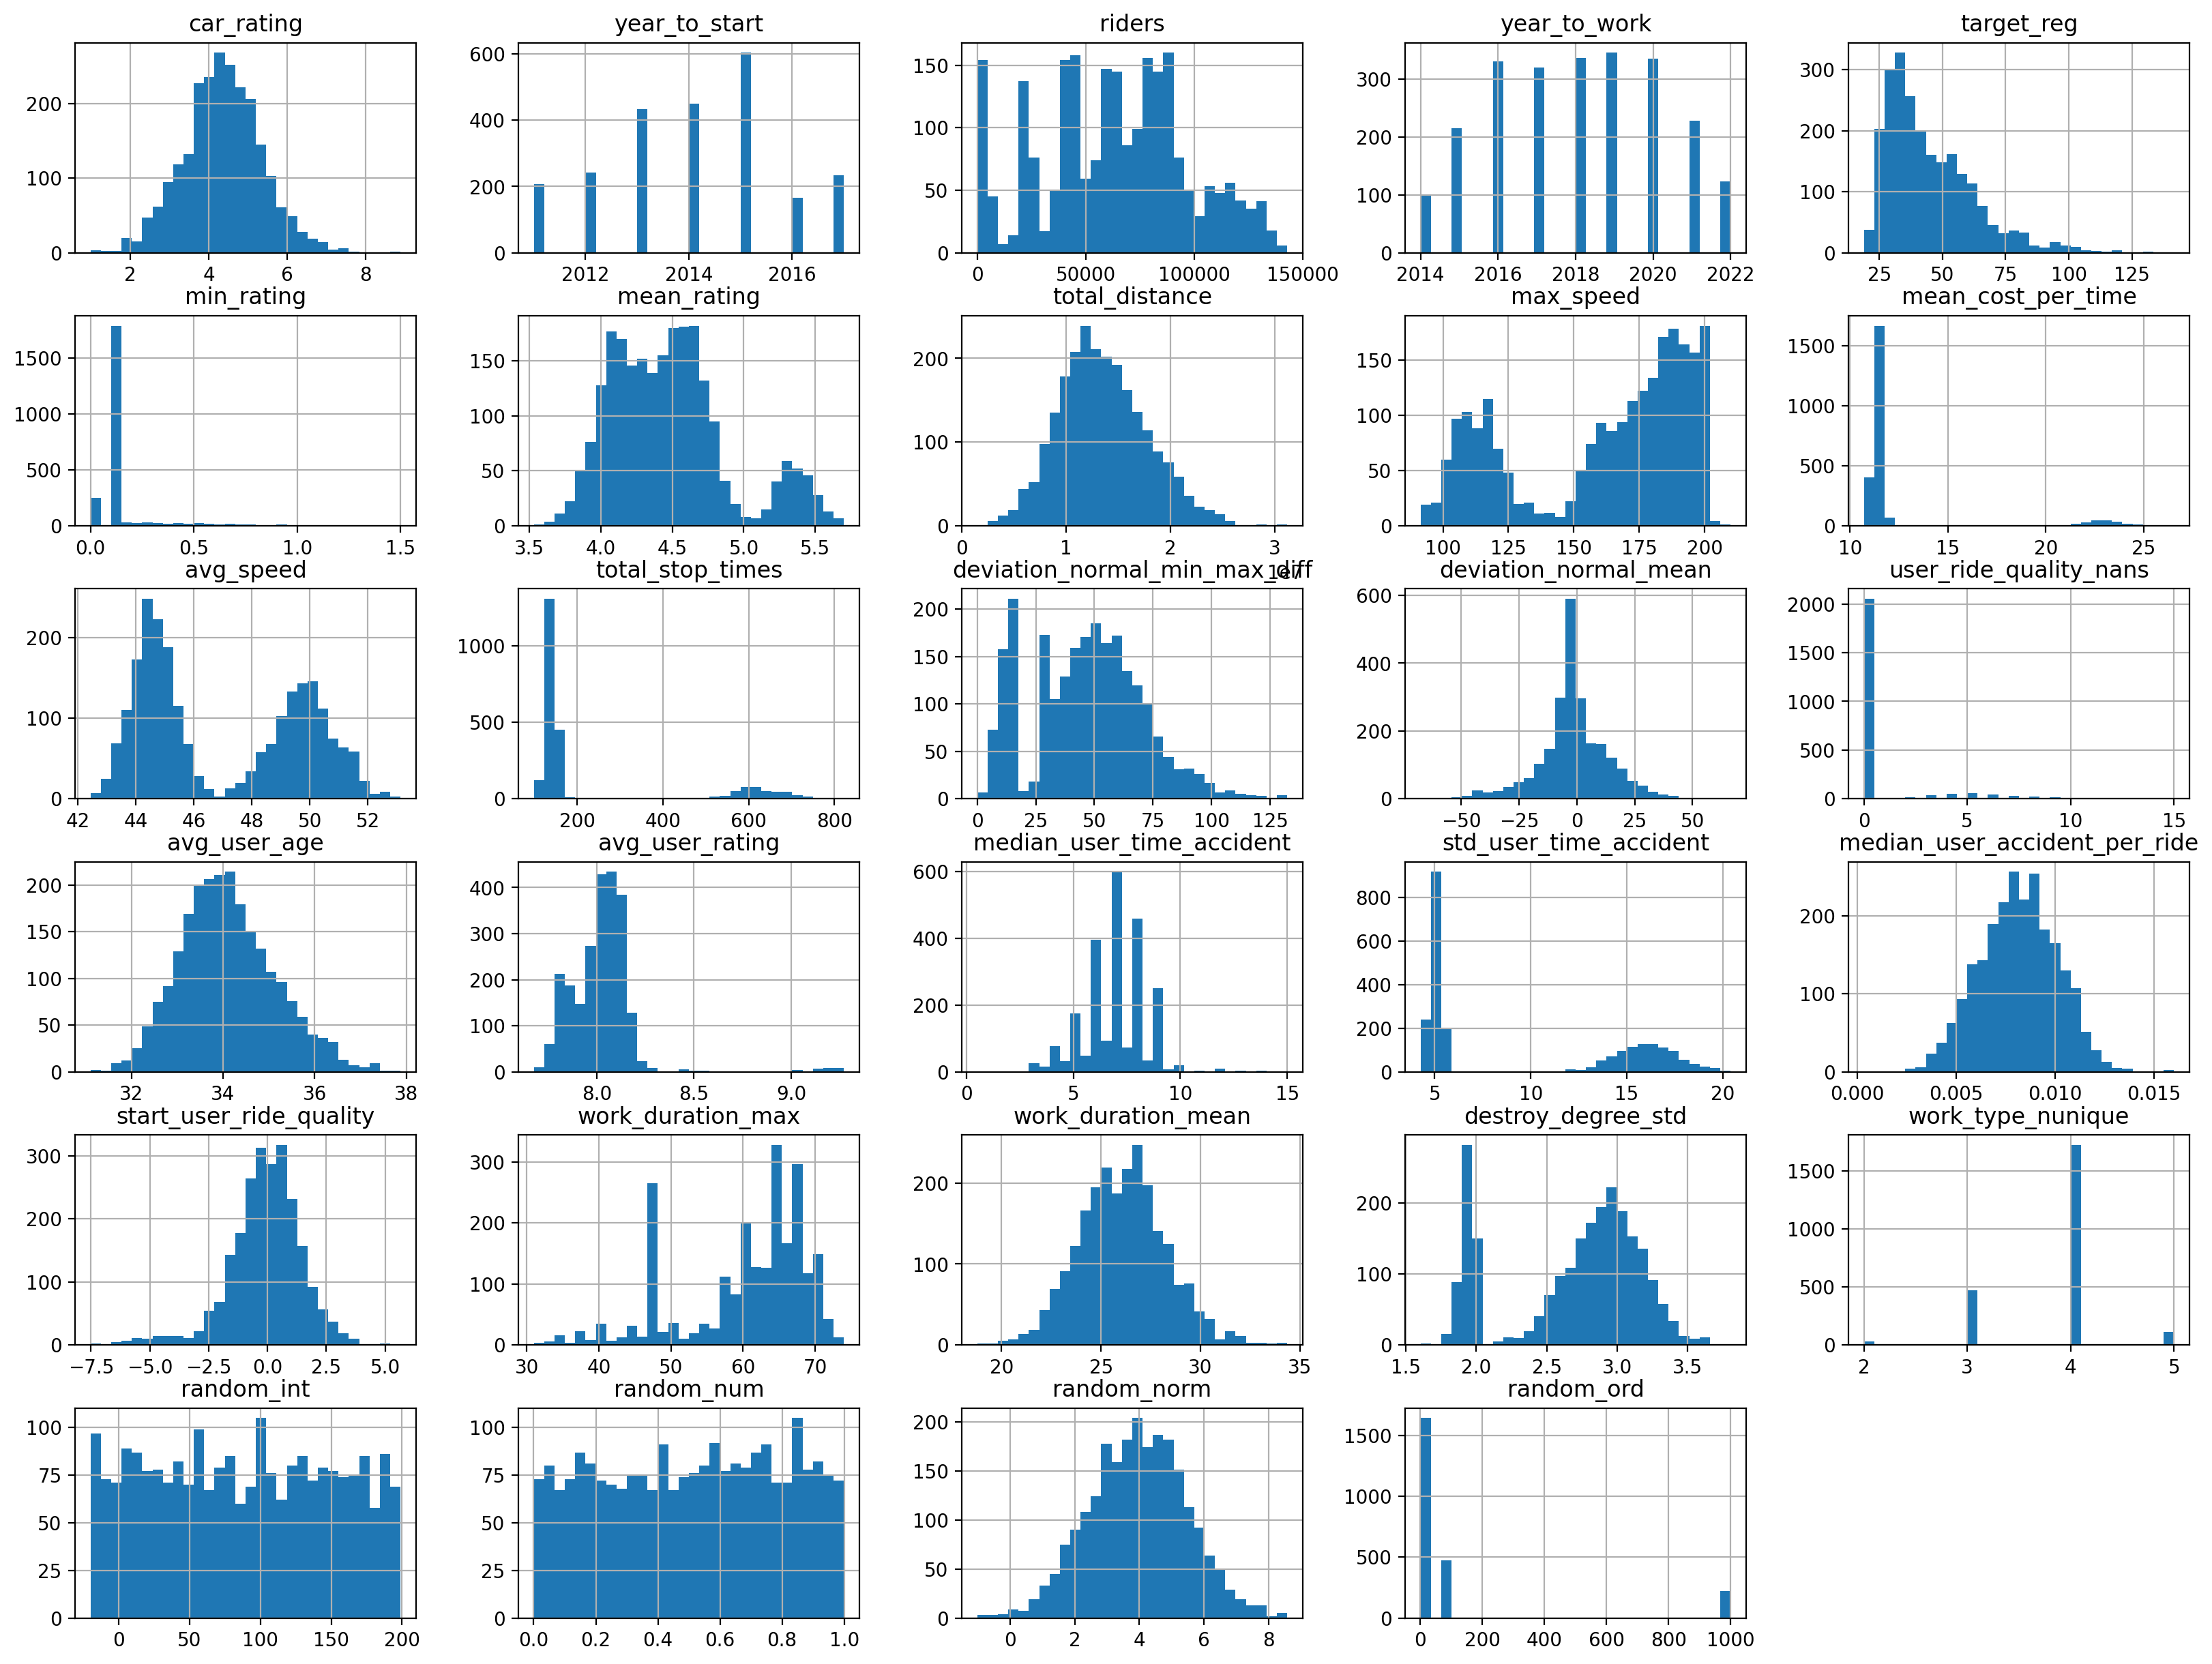

In [44]:
# Добавление рандомных признаков

# Целочисленный признак
car_train_features['random_int'] = np.random.randint(-20, 200, car_train_features.shape[0])

# Признак типа float с равномерным распределением
car_train_features['random_num'] = np.random.random(size = car_train_features.shape[0])

# Признак с нормальным распределением
car_train_features['random_norm'] = np.random.normal(loc = 4, scale = 1.5, size = car_train_features.shape[0])

# Категориальный признак str формата с дисбалансом
car_train_features['random_cat'] = np.random.choice(['A', 'B', 'C', 'D'], p = [0.20, 0.3, 0.45, 0.05], 
                                                    size = car_train_features.shape[0]) 

# Численный категориальный признак
car_train_features['random_ord'] = np.random.choice([1, 10, 100, 1000], p = [0.40, 0.3, 0.2, 0.1], 
                                                    size = car_train_features.shape[0])

car_train_features.hist(figsize = (20, 15), layout = (-1, 5), bins=30);

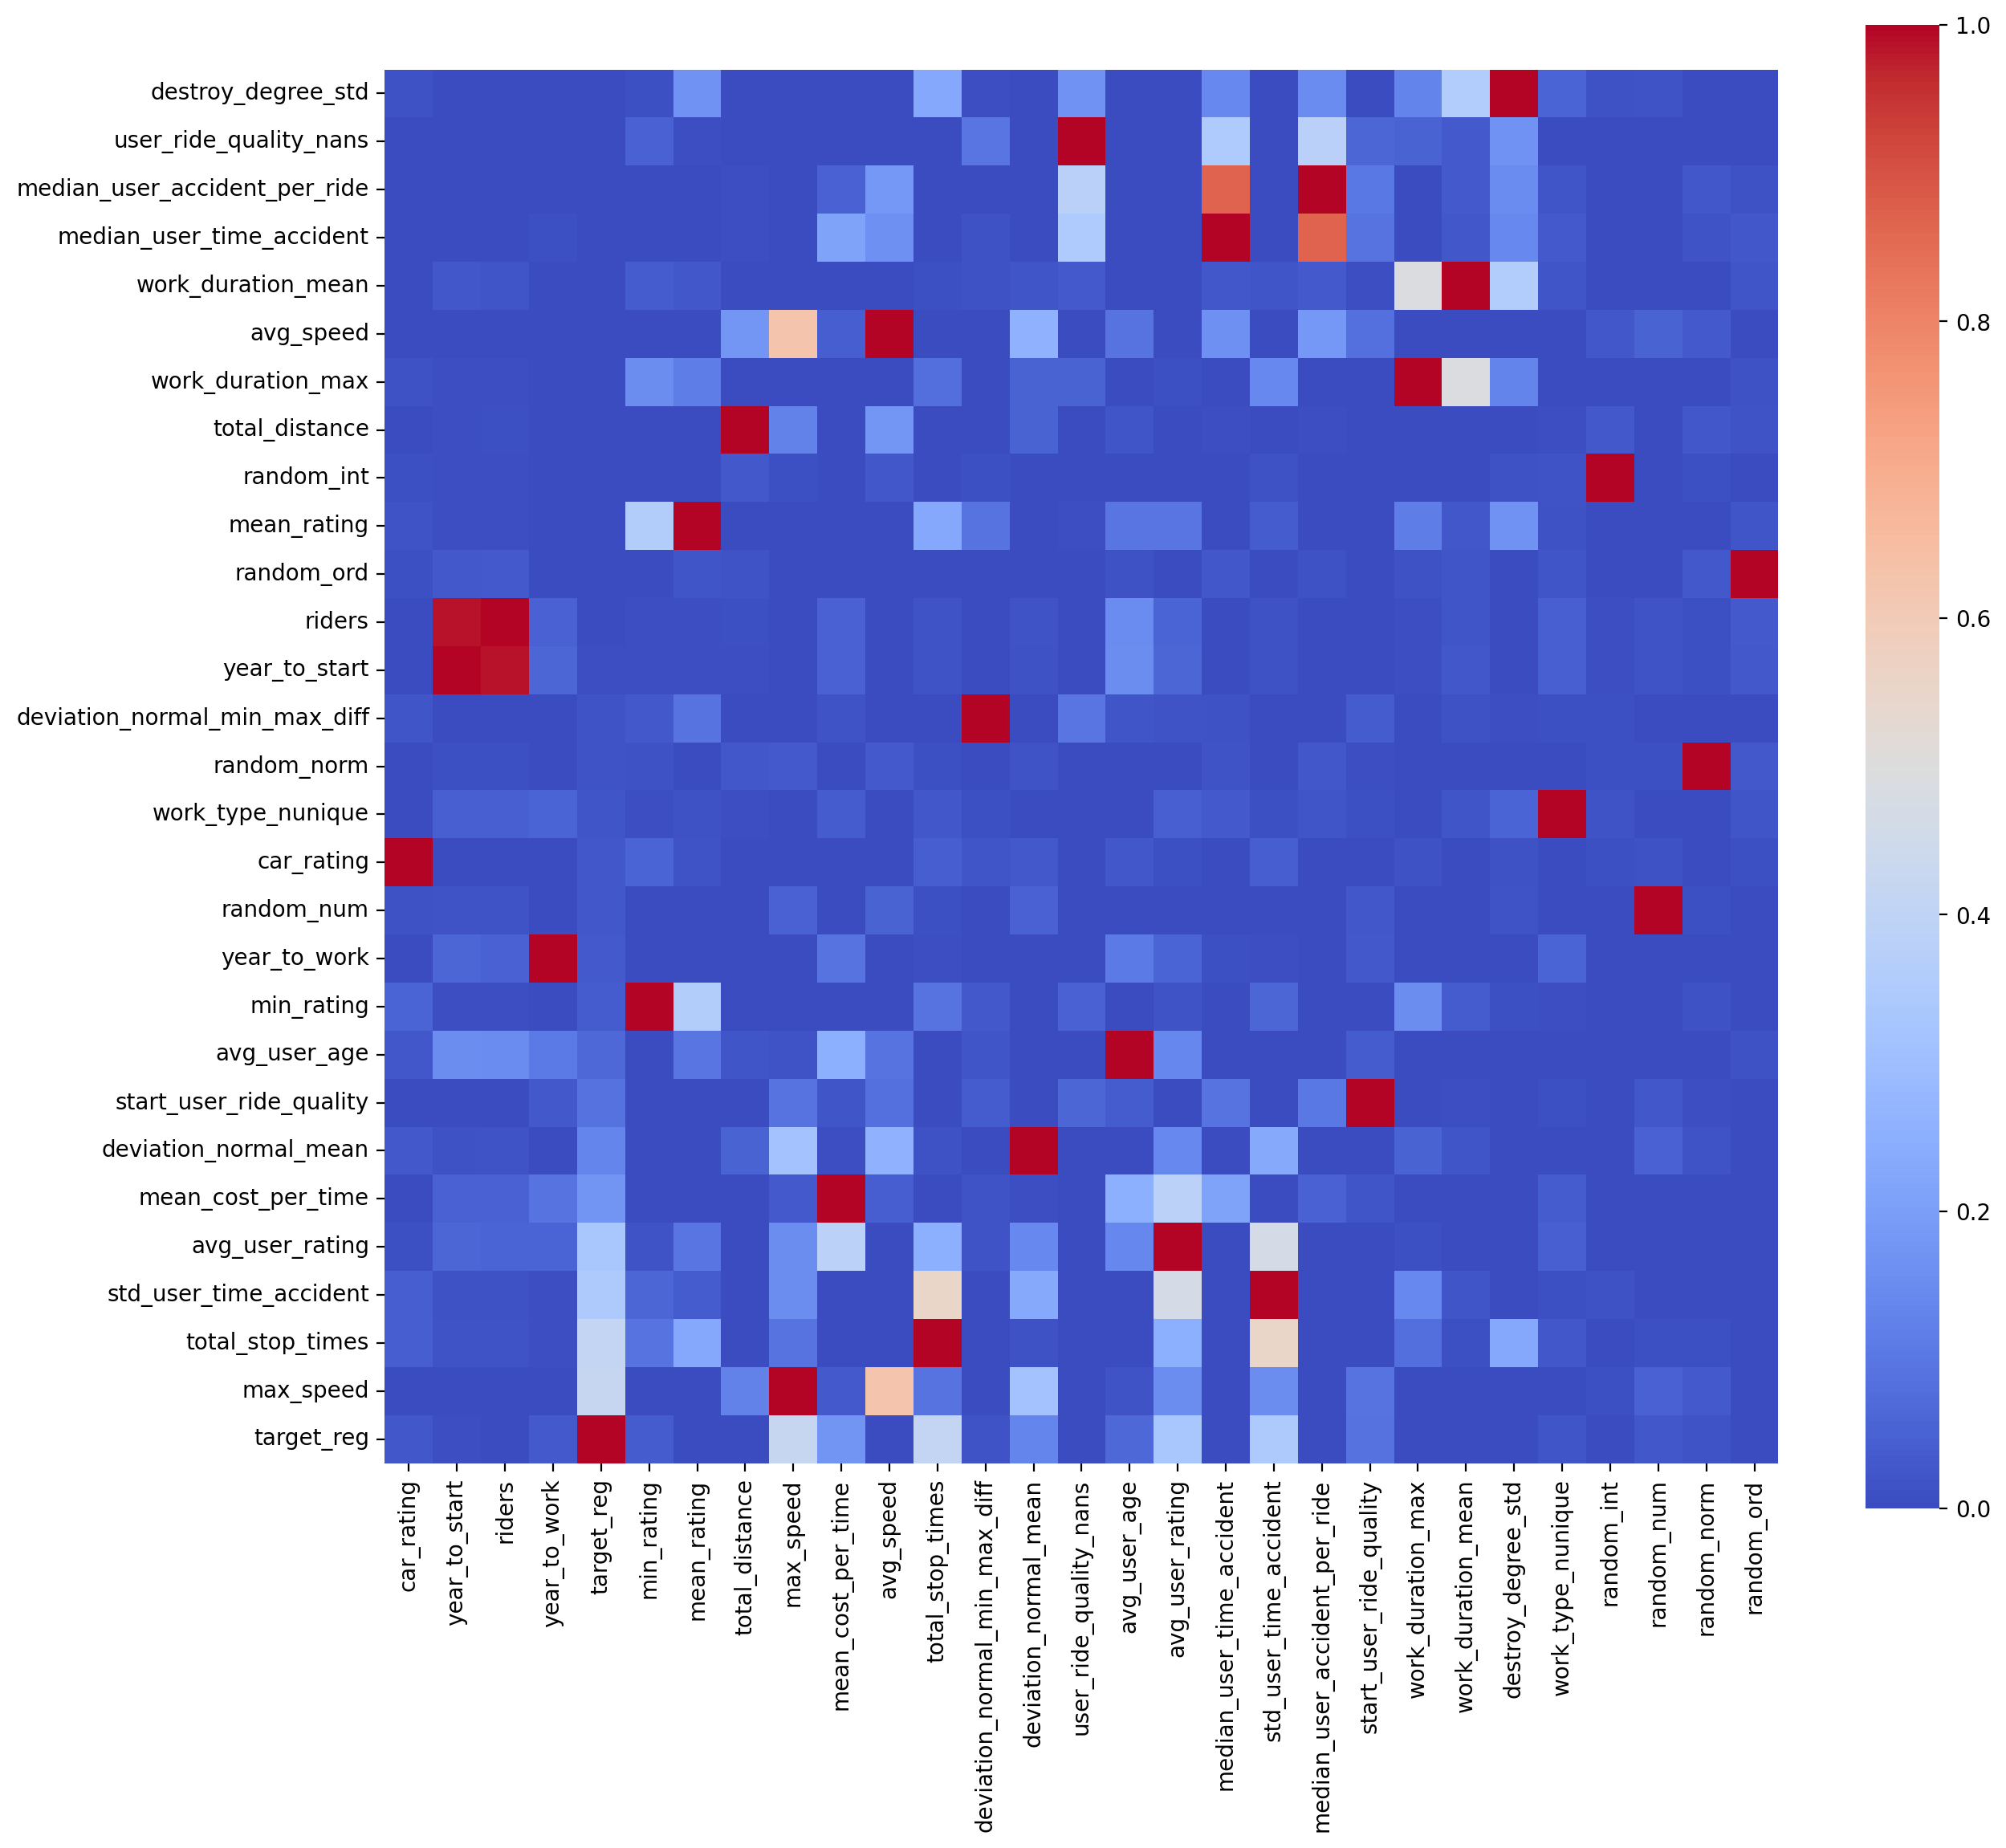

In [45]:
# 1. Линейная корреляция
corrs = car_train_features.corr(numeric_only=True).round(3).sort_values('target_reg')
plt.figure(figsize=(14, 12))
sns.heatmap(corrs, cmap='coolwarm', square=True, vmin = 0)
plt.show()

Сильная положительная корреляция между year_to_start и riders, также наблюдается корреляция между колонками median_user_accident_per_ride и median_user_time_accident. Слабая корреляция с колонкой target_reg у max_speed, total_stop_times, std_user_time_accident, avg_user_rating

In [46]:
#!pip install phik -q

In [47]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'total_distance', 'max_speed', 'mean_cost_per_time', 'avg_speed', 'total_stop_times', 'deviation_normal_min_max_diff', 'deviation_normal_mean', 'user_ride_quality_nans', 'avg_user_age', 'avg_user_rating', 'median_user_time_accident', 'std_user_time_accident', 'median_user_accident_per_ride', 'start_user_ride_quality', 'work_duration_max', 'work_duration_mean', 'destroy_degree_std', 'work_type_nunique', 'random_int', 'random_num', 'random_norm', 'random_ord']


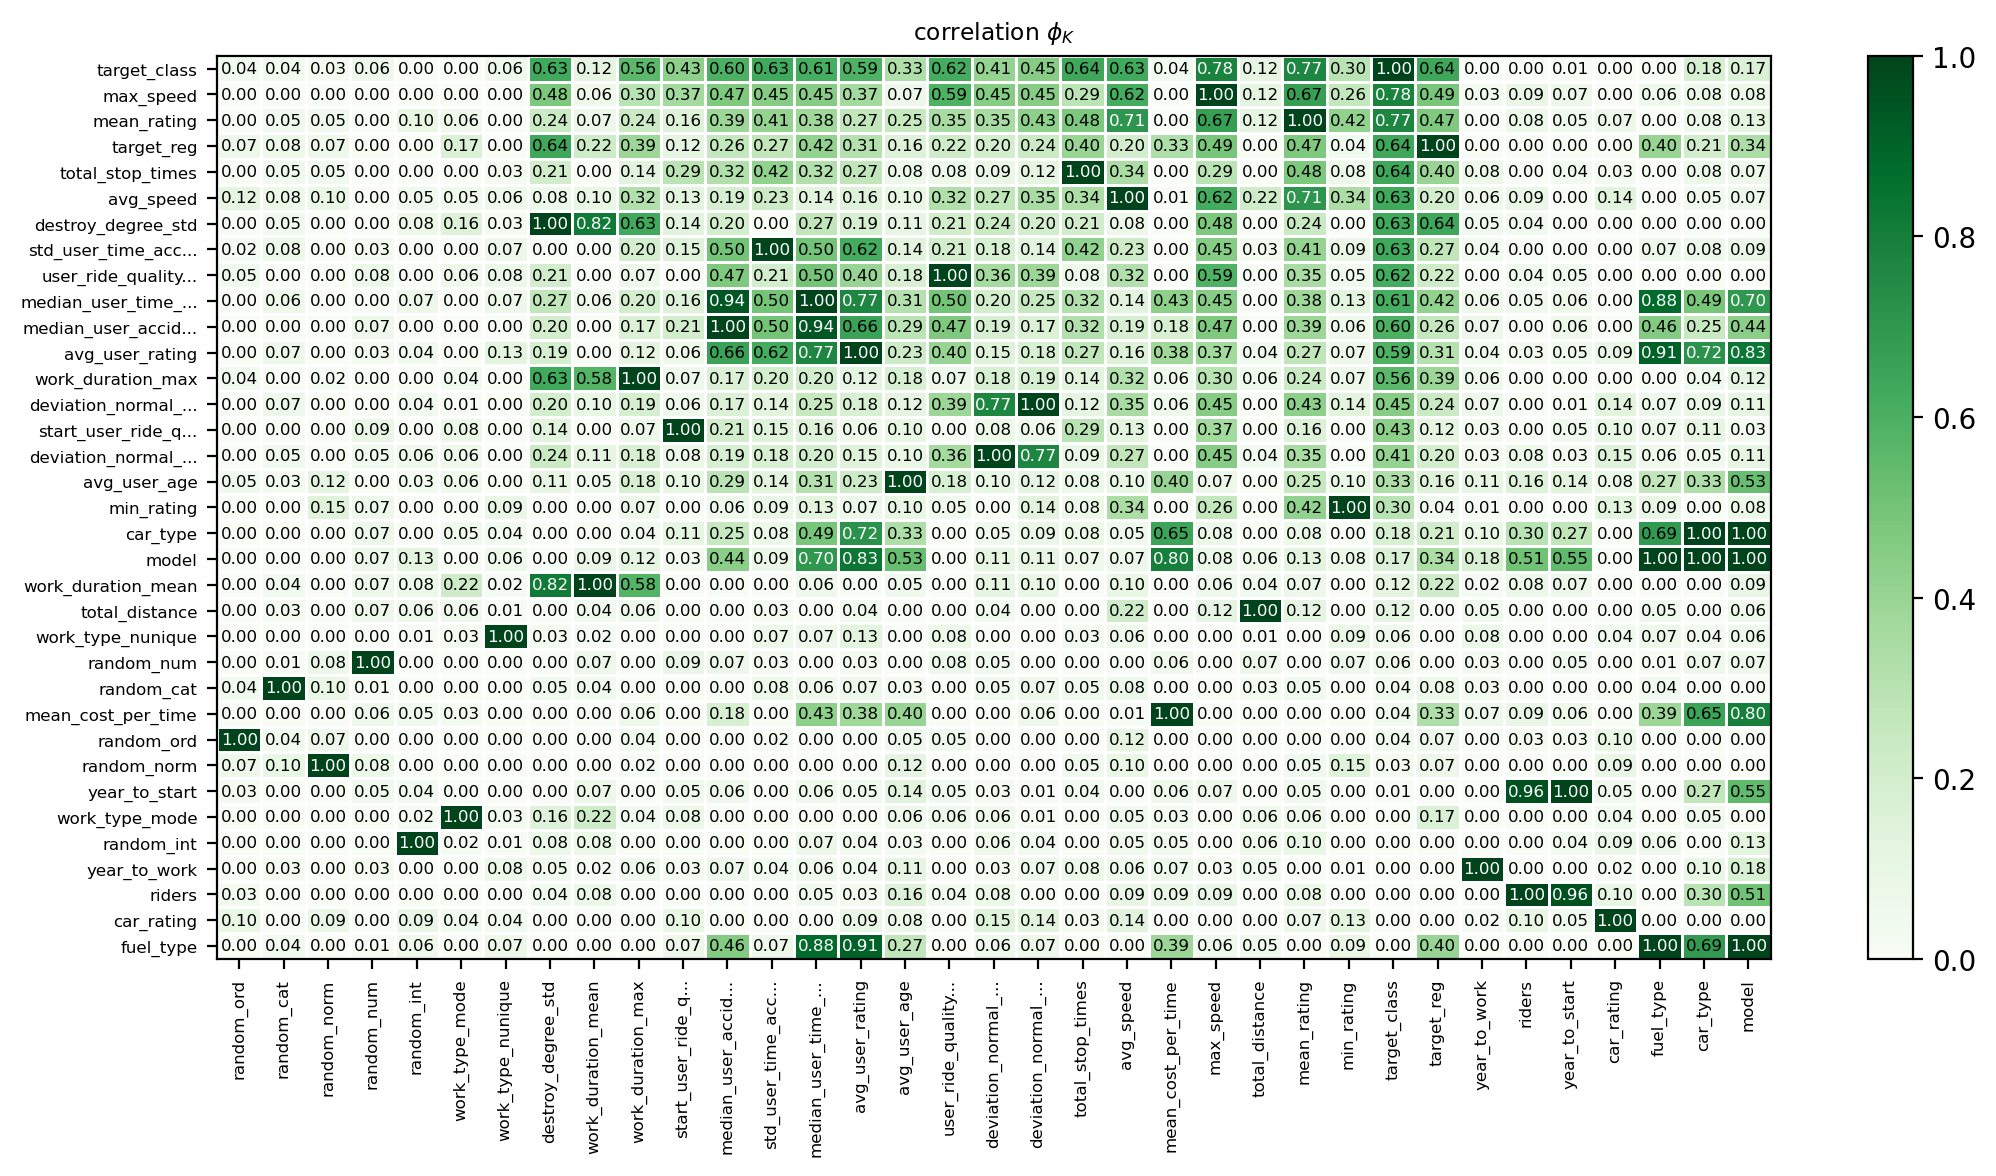

In [48]:
# 2. Phik
phik_overview = car_train_features.phik_matrix().round(2).sort_values('target_class')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=0.6, figsize=(11, 6))
plt.tight_layout()
plt.show()

Корреляция с target_class наблюдается у max_speed, min_rating, total_stop_times, avg_speed, destroy_degree_std, std_user_time_accident, user_ride_quality_nans, median_user_time_accident, median_user_accident_per_ride, avg_user_rating  
корреляции между признаками: work_duration_mean и destroy_degree_std, median_user_time_accident и median_user_accident_per_ride, fuel_type и median_user_time_accident, fuel_type и avg_user_rating, model и avg_user_rating, model и mean_cost_per_time, year_to_start и riders

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'total_distance', 'max_speed', 'mean_cost_per_time', 'avg_speed', 'total_stop_times', 'deviation_normal_min_max_diff', 'deviation_normal_mean', 'user_ride_quality_nans', 'avg_user_age', 'avg_user_rating', 'median_user_time_accident', 'std_user_time_accident', 'median_user_accident_per_ride', 'start_user_ride_quality', 'work_duration_max', 'work_duration_mean', 'destroy_degree_std', 'work_type_nunique', 'random_int', 'random_num', 'random_norm', 'random_ord']


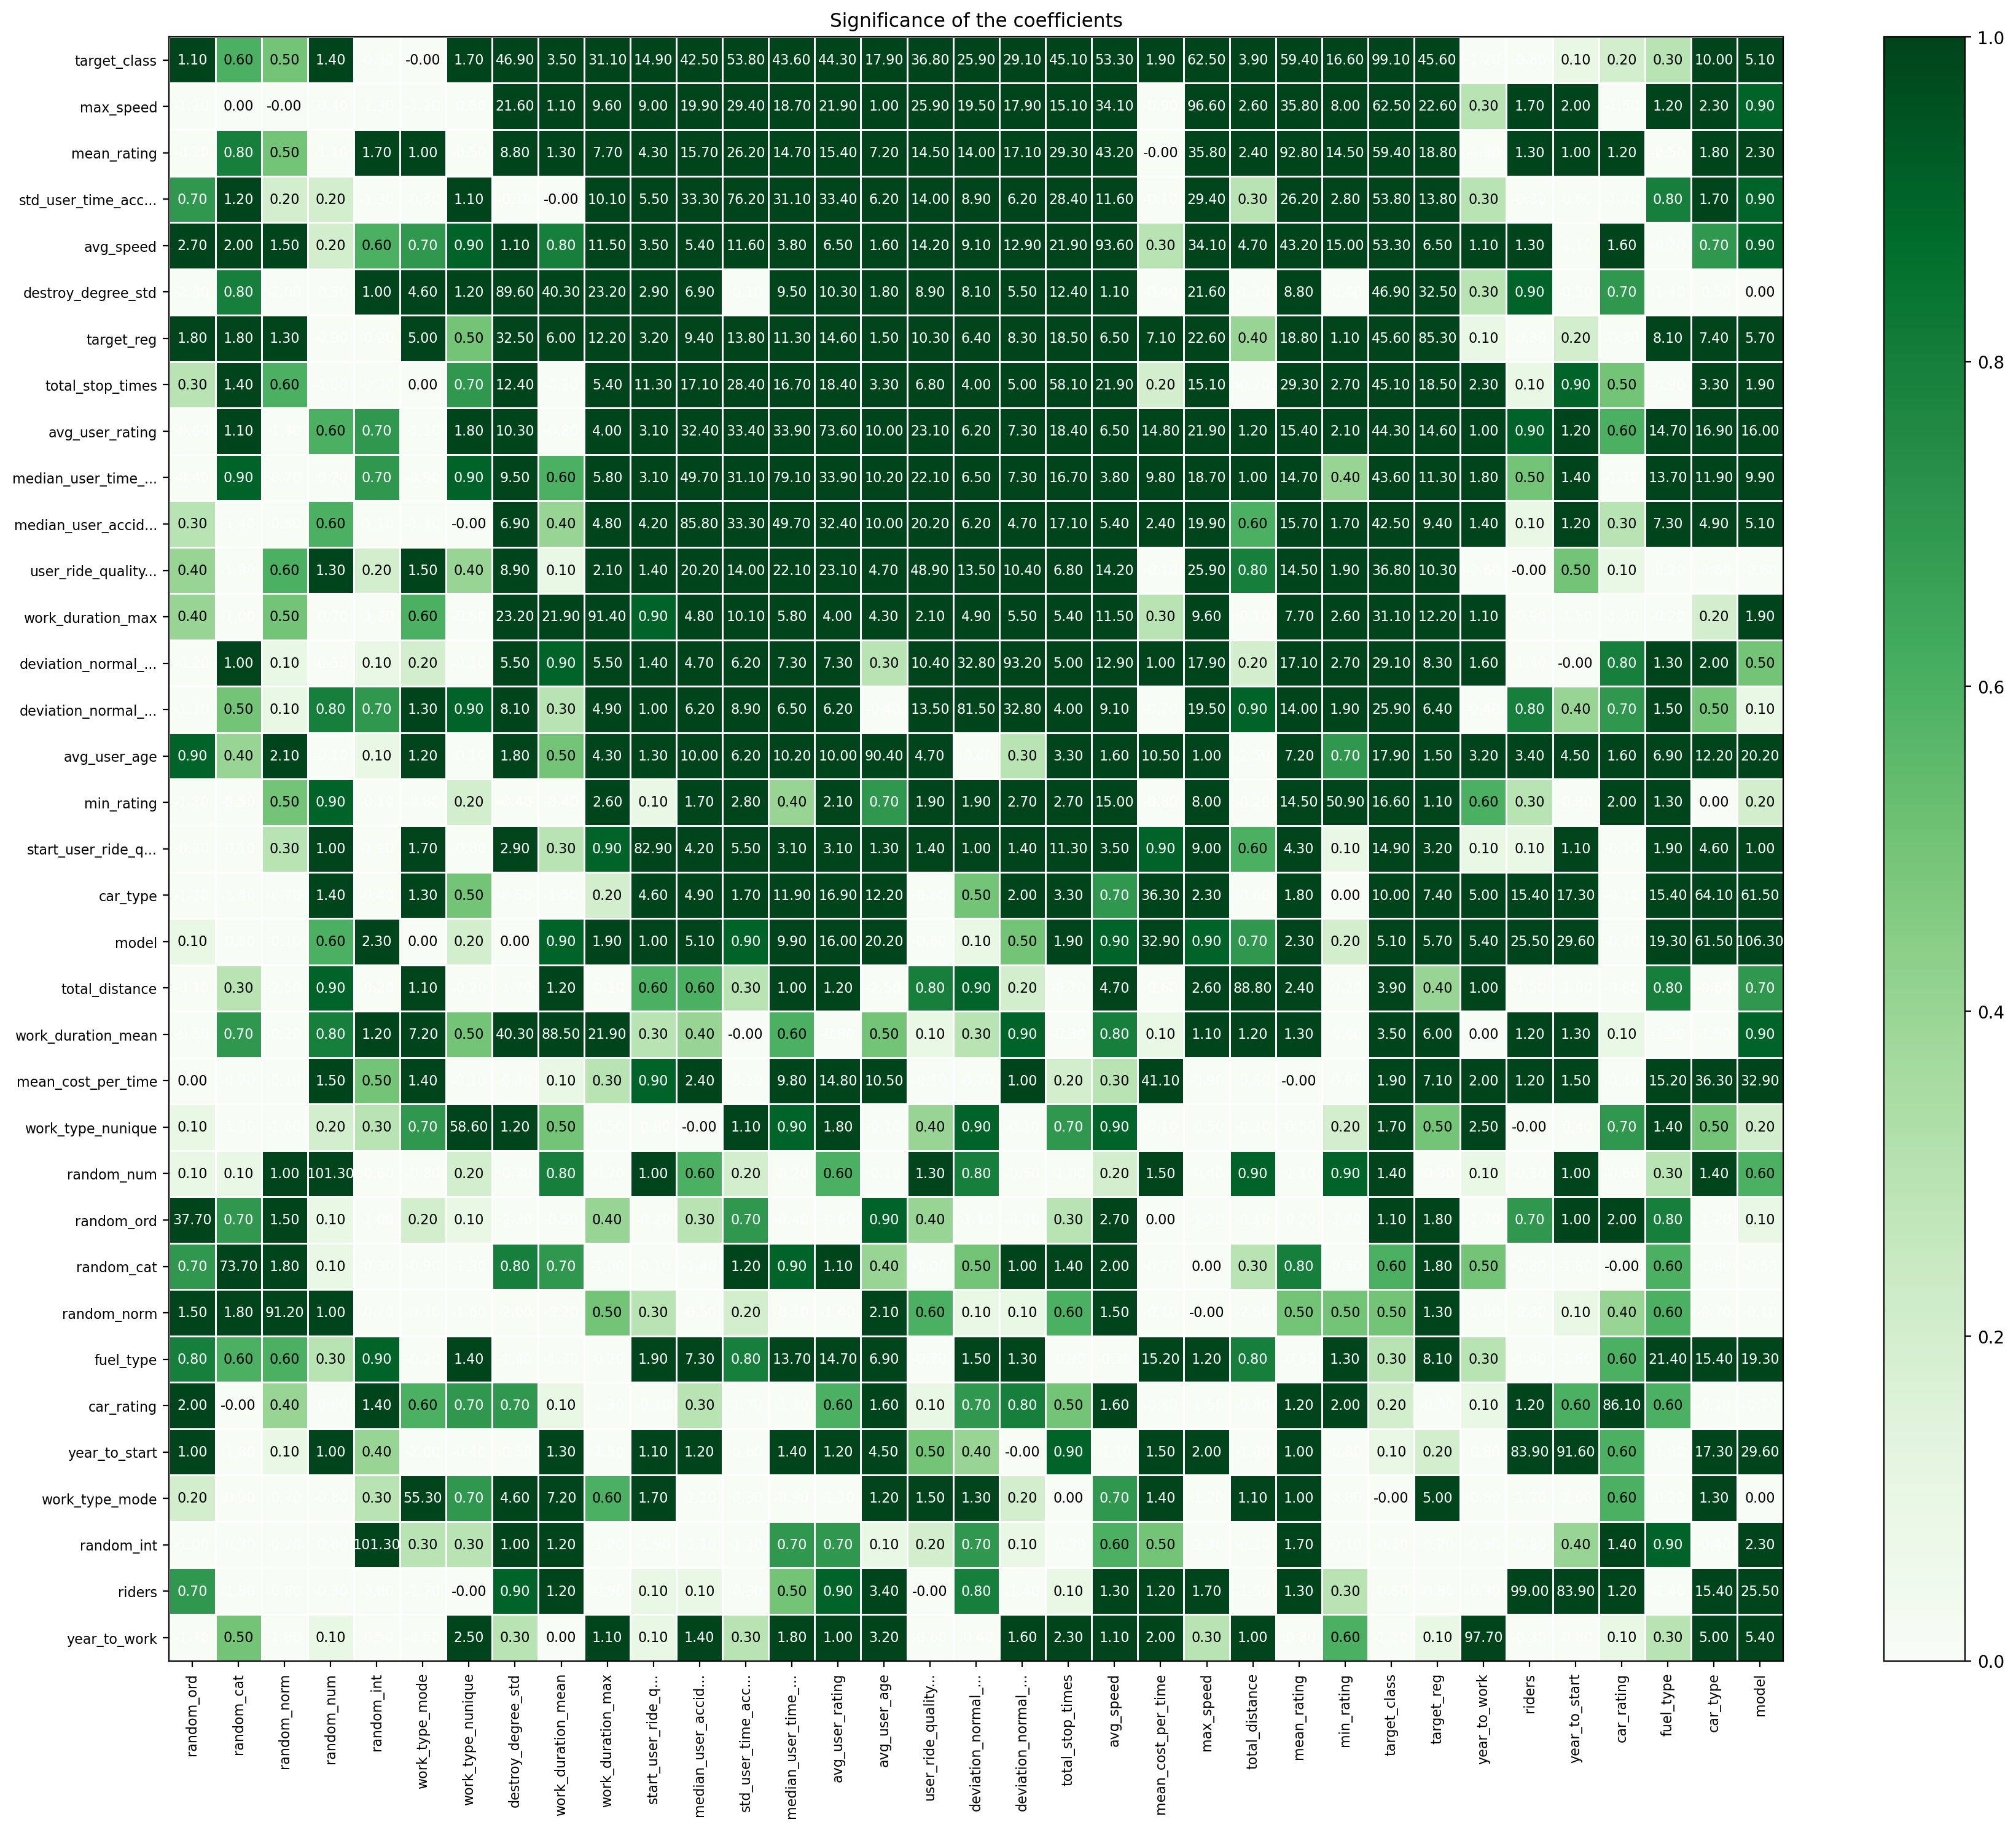

In [49]:
significance_overview = car_train_features.significance_matrix().fillna(0).round(1).sort_values('target_class')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=0.8, figsize=(18, 15))
plt.tight_layout()

Значимость коэффициентов для target_class: max_speed, mean_rating, std_user_time_accident, avg_speed, destroy_degree_std, total_stop_times, avg_user_rating, median_user_time_accident, median_user_accident_per_ride, user_ride_quality_nans, work_duration_max, deviation_normal_min_max_diff, deviation_normal_mean, avg_user_age, min_rating, start_user_ride_quality, car_type, model.

In [50]:
# 3. Feature Importance
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split

In [51]:
# Распределенность классов
car_train_features['target_class'].value_counts(normalize=True)

engine_overheat    0.123663
gear_stick         0.121523
another_bug        0.119384
engine_check       0.115533
break_bug          0.115533
engine_ignition    0.115105
engine_fuel        0.112110
electro_bug        0.106547
wheel_shake        0.070603
Name: target_class, dtype: float64

In [52]:
# Подготовка данных, разделение на train и test
drop_cols = ['target_class', 'target_reg']
cat_cols = ['model', 'car_type', 'fuel_type', 'work_type_mode', 'random_cat']

X = car_train_features.drop(drop_cols, axis=1)
y = car_train_features['target_class'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
# Инициализация и обучение модели CatBoostClassifier
model = CatBoostClassifier(random_state=42,
                           cat_features=cat_cols,
                           thread_count=-1)
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.5990128	test: 1.6098900	best: 1.6098900 (0)	total: 416ms	remaining: 6m 56s
100:	learn: 0.0271525	test: 0.0346609	best: 0.0346609 (100)	total: 23.4s	remaining: 3m 28s
200:	learn: 0.0121388	test: 0.0242266	best: 0.0242266 (200)	total: 47s	remaining: 3m 6s
300:	learn: 0.0078112	test: 0.0215817	best: 0.0215817 (300)	total: 1m 10s	remaining: 2m 43s
400:	learn: 0.0052766	test: 0.0204080	best: 0.0203572 (390)	total: 1m 35s	remaining: 2m 22s
500:	learn: 0.0039286	test: 0.0200637	best: 0.0200637 (500)	total: 1m 59s	remaining: 1m 58s
600:	learn: 0.0032316	test: 0.0201008	best: 0.0199778 (561)	total: 2m 22s	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.01997779226
bestIteration = 561

Shrink model to first 562 iterations.


In [54]:
# Важность признаков CatBoostClassifier
fi = model.get_feature_importance(prettified=True)
fi

Feature Id  Importances
0              destroy_degree_std    23.449008
1          std_user_time_accident    17.422445
2                       max_speed    13.087582
3                       avg_speed    12.042494
4                 avg_user_rating     8.649307
5                     mean_rating     5.386060
6                total_stop_times     5.168435
7                      min_rating     4.896046
8       median_user_time_accident     2.746590
9          user_ride_quality_nans     2.171222
10  median_user_accident_per_ride     0.793416
11                          model     0.726296
12                     random_cat     0.580213
13              work_duration_max     0.573891
14  deviation_normal_min_max_diff     0.376742
15        start_user_ride_quality     0.374932
16                   avg_user_age     0.292419
17                       car_type     0.263308
18                         riders     0.138146
19             work_duration_mean     0.137958
20                    random_norm     0.136852
21             mean_cost_per_time     0.097666
22                 total_distance     0.092871
23          deviation_normal_mean     0.071081
24                     car_rating     0.058091
25                     random_num     0.057737
26                     random_int     0.051883
27                     random_ord     0.051531
28                   year_to_work     0.040548
29              work_type_nunique     0.036058
30                 work_type_mode     0.021952
31                  year_to_start     0.006547
32                      fuel_type     0.000674

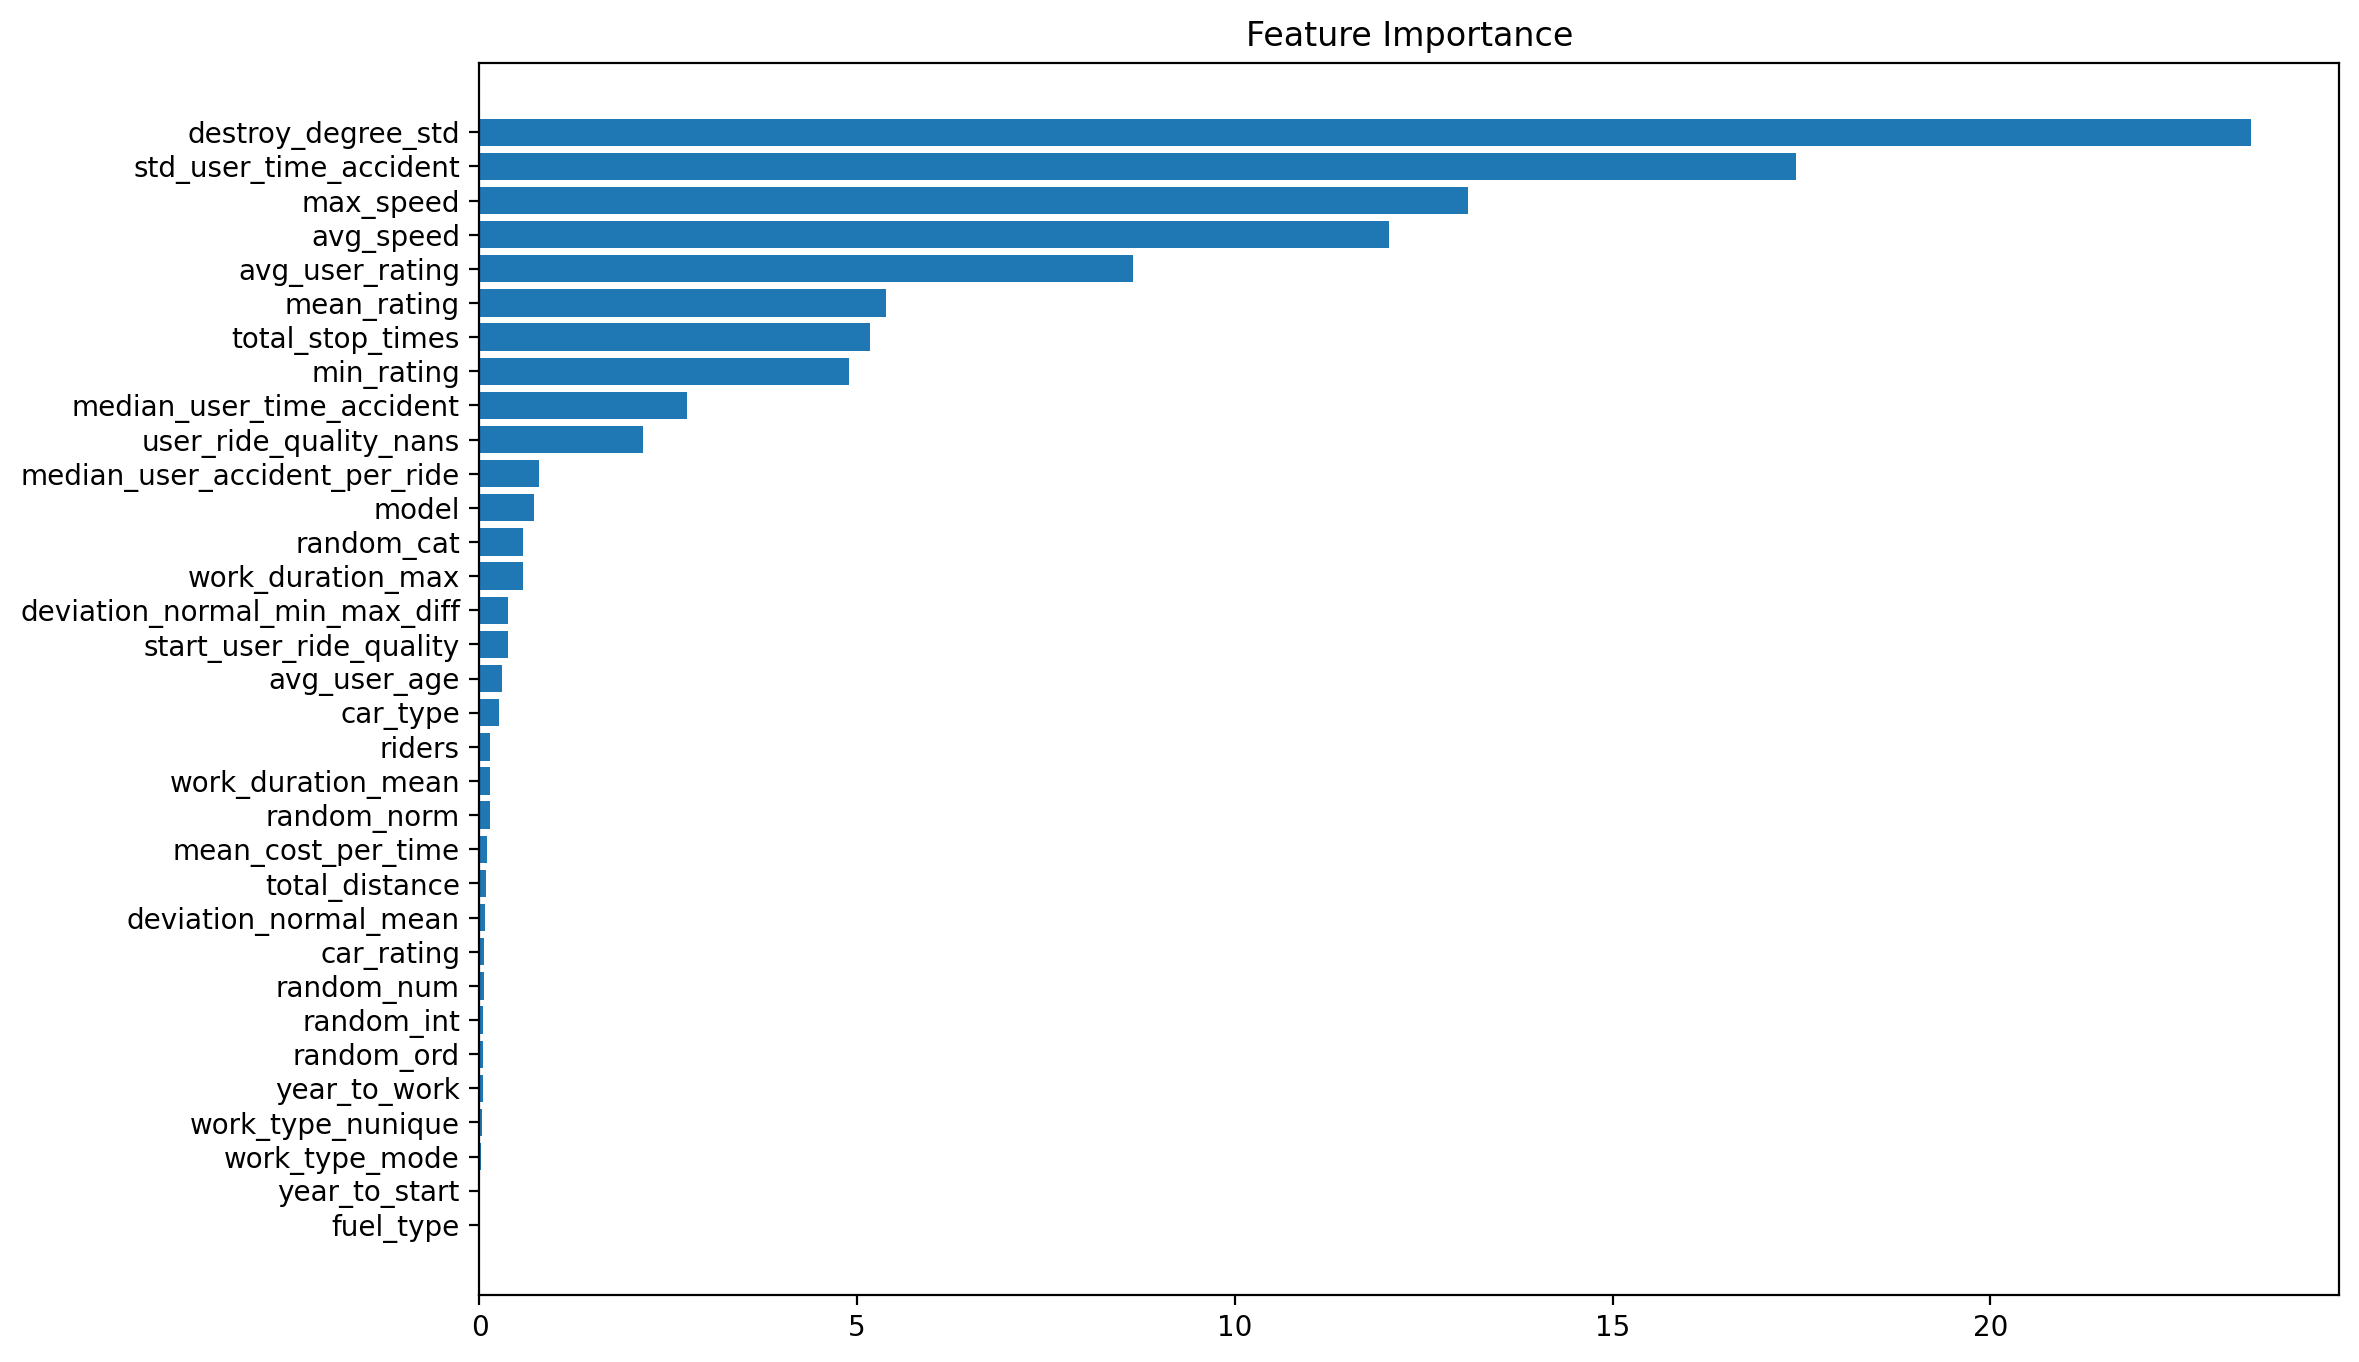

In [55]:
# Визуализация важности признаков CatBoostClassifier
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

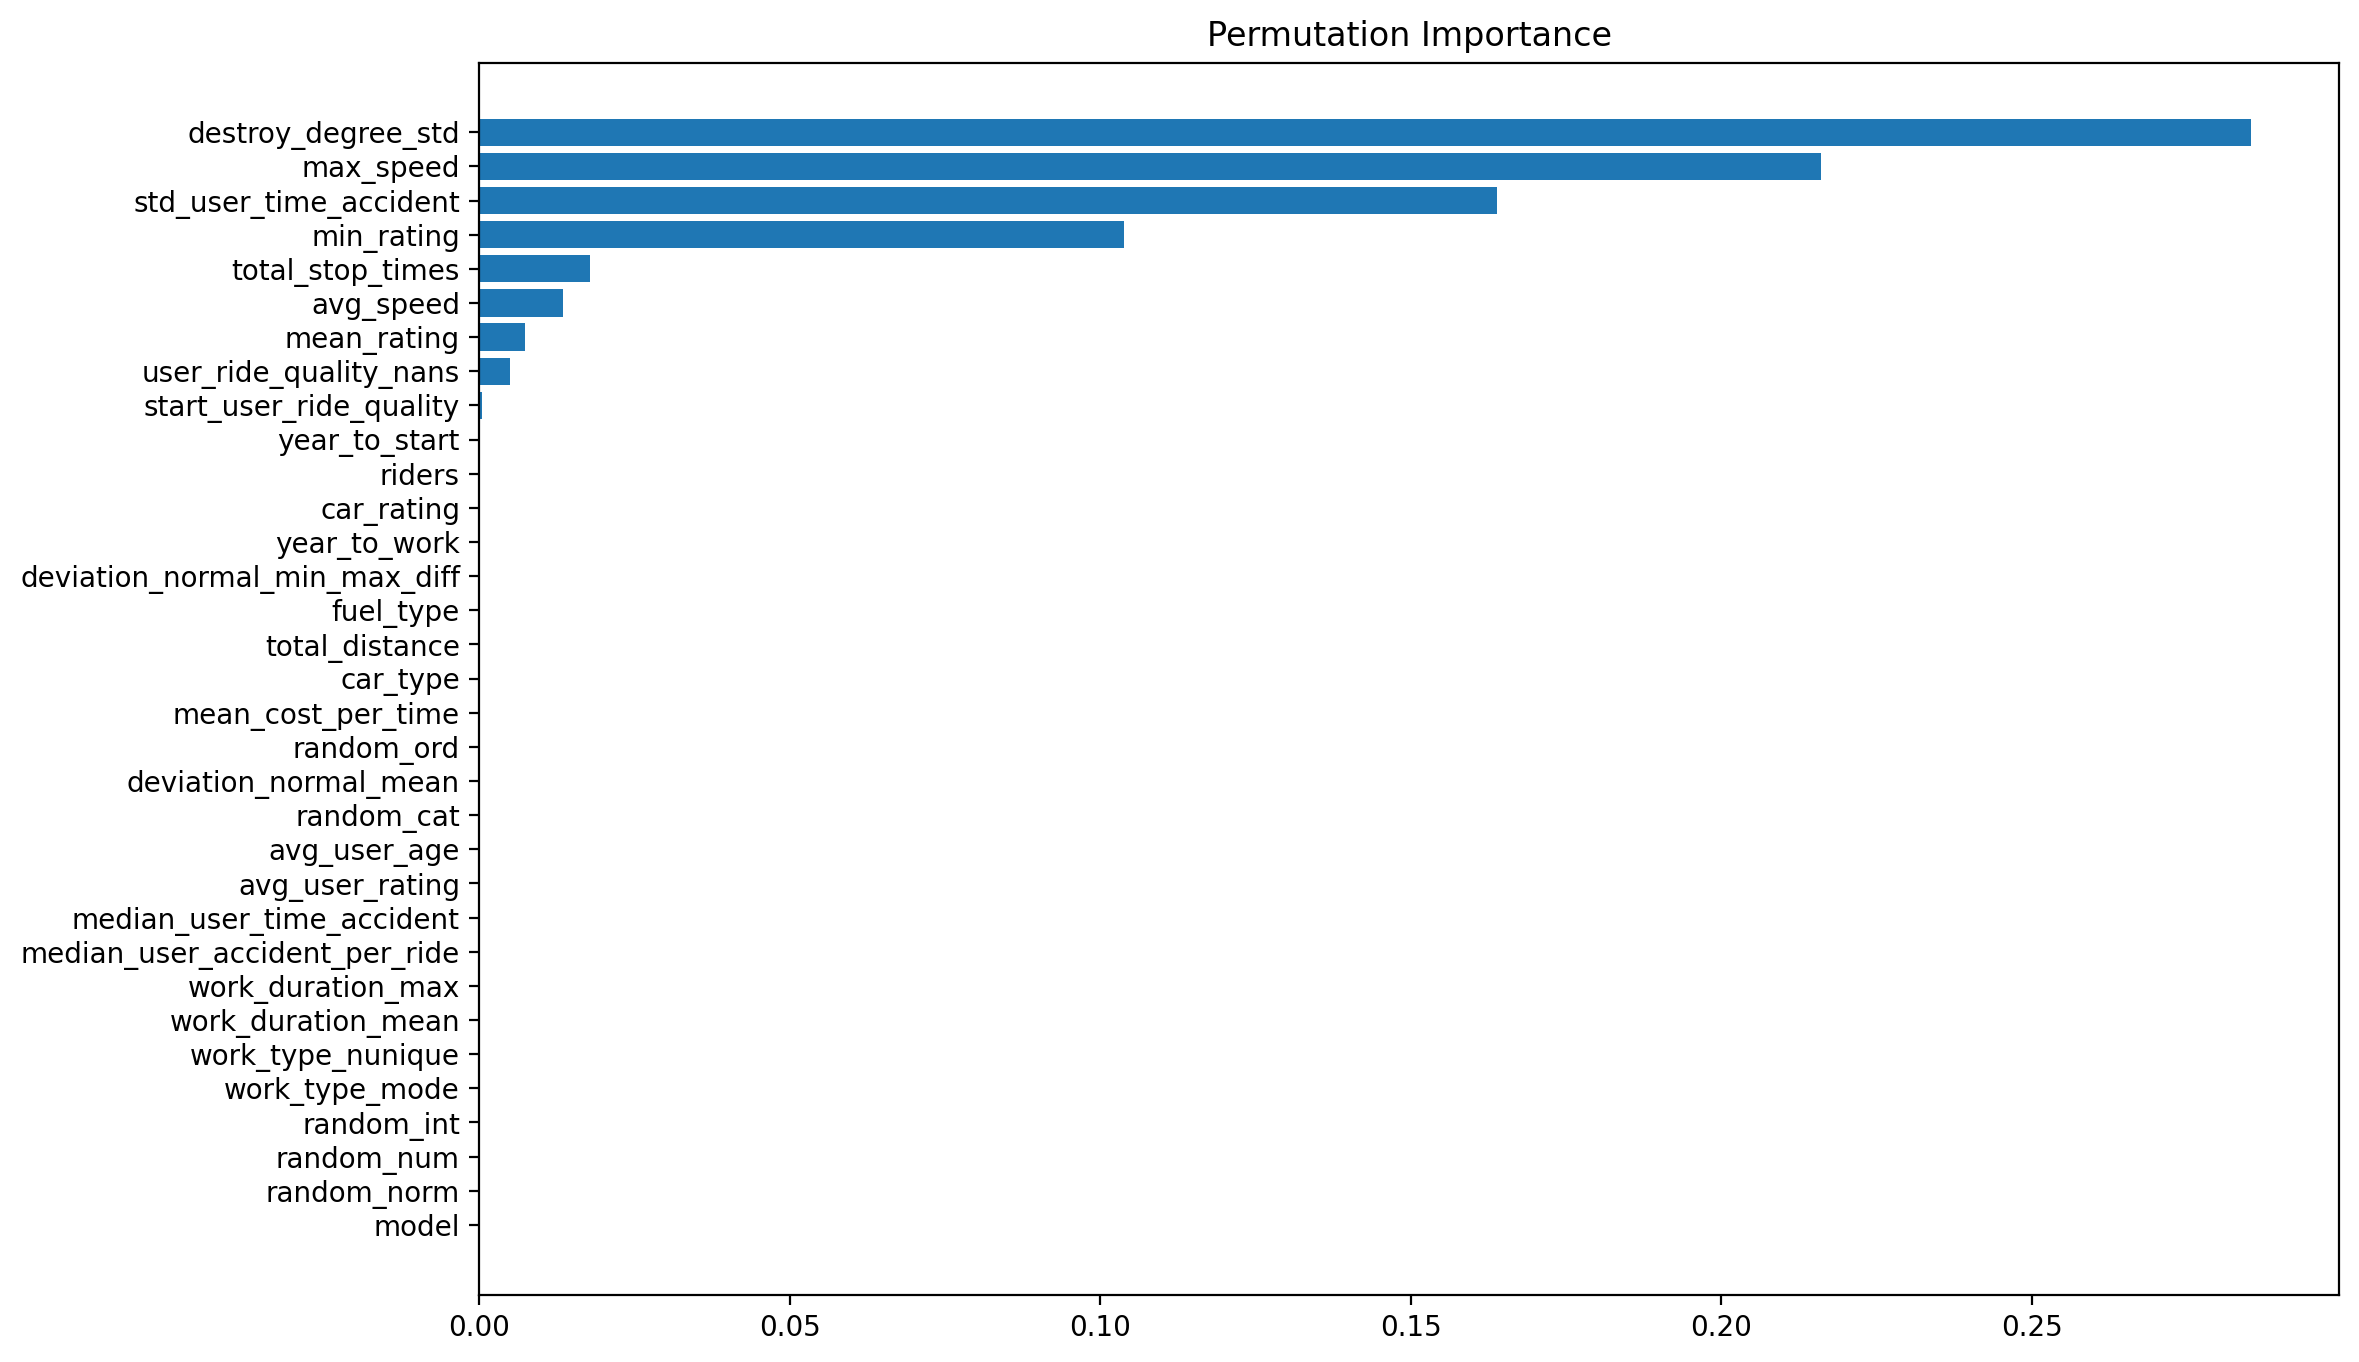

In [56]:
# 4. Permutation Importance
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [57]:
#!pip install shap -q

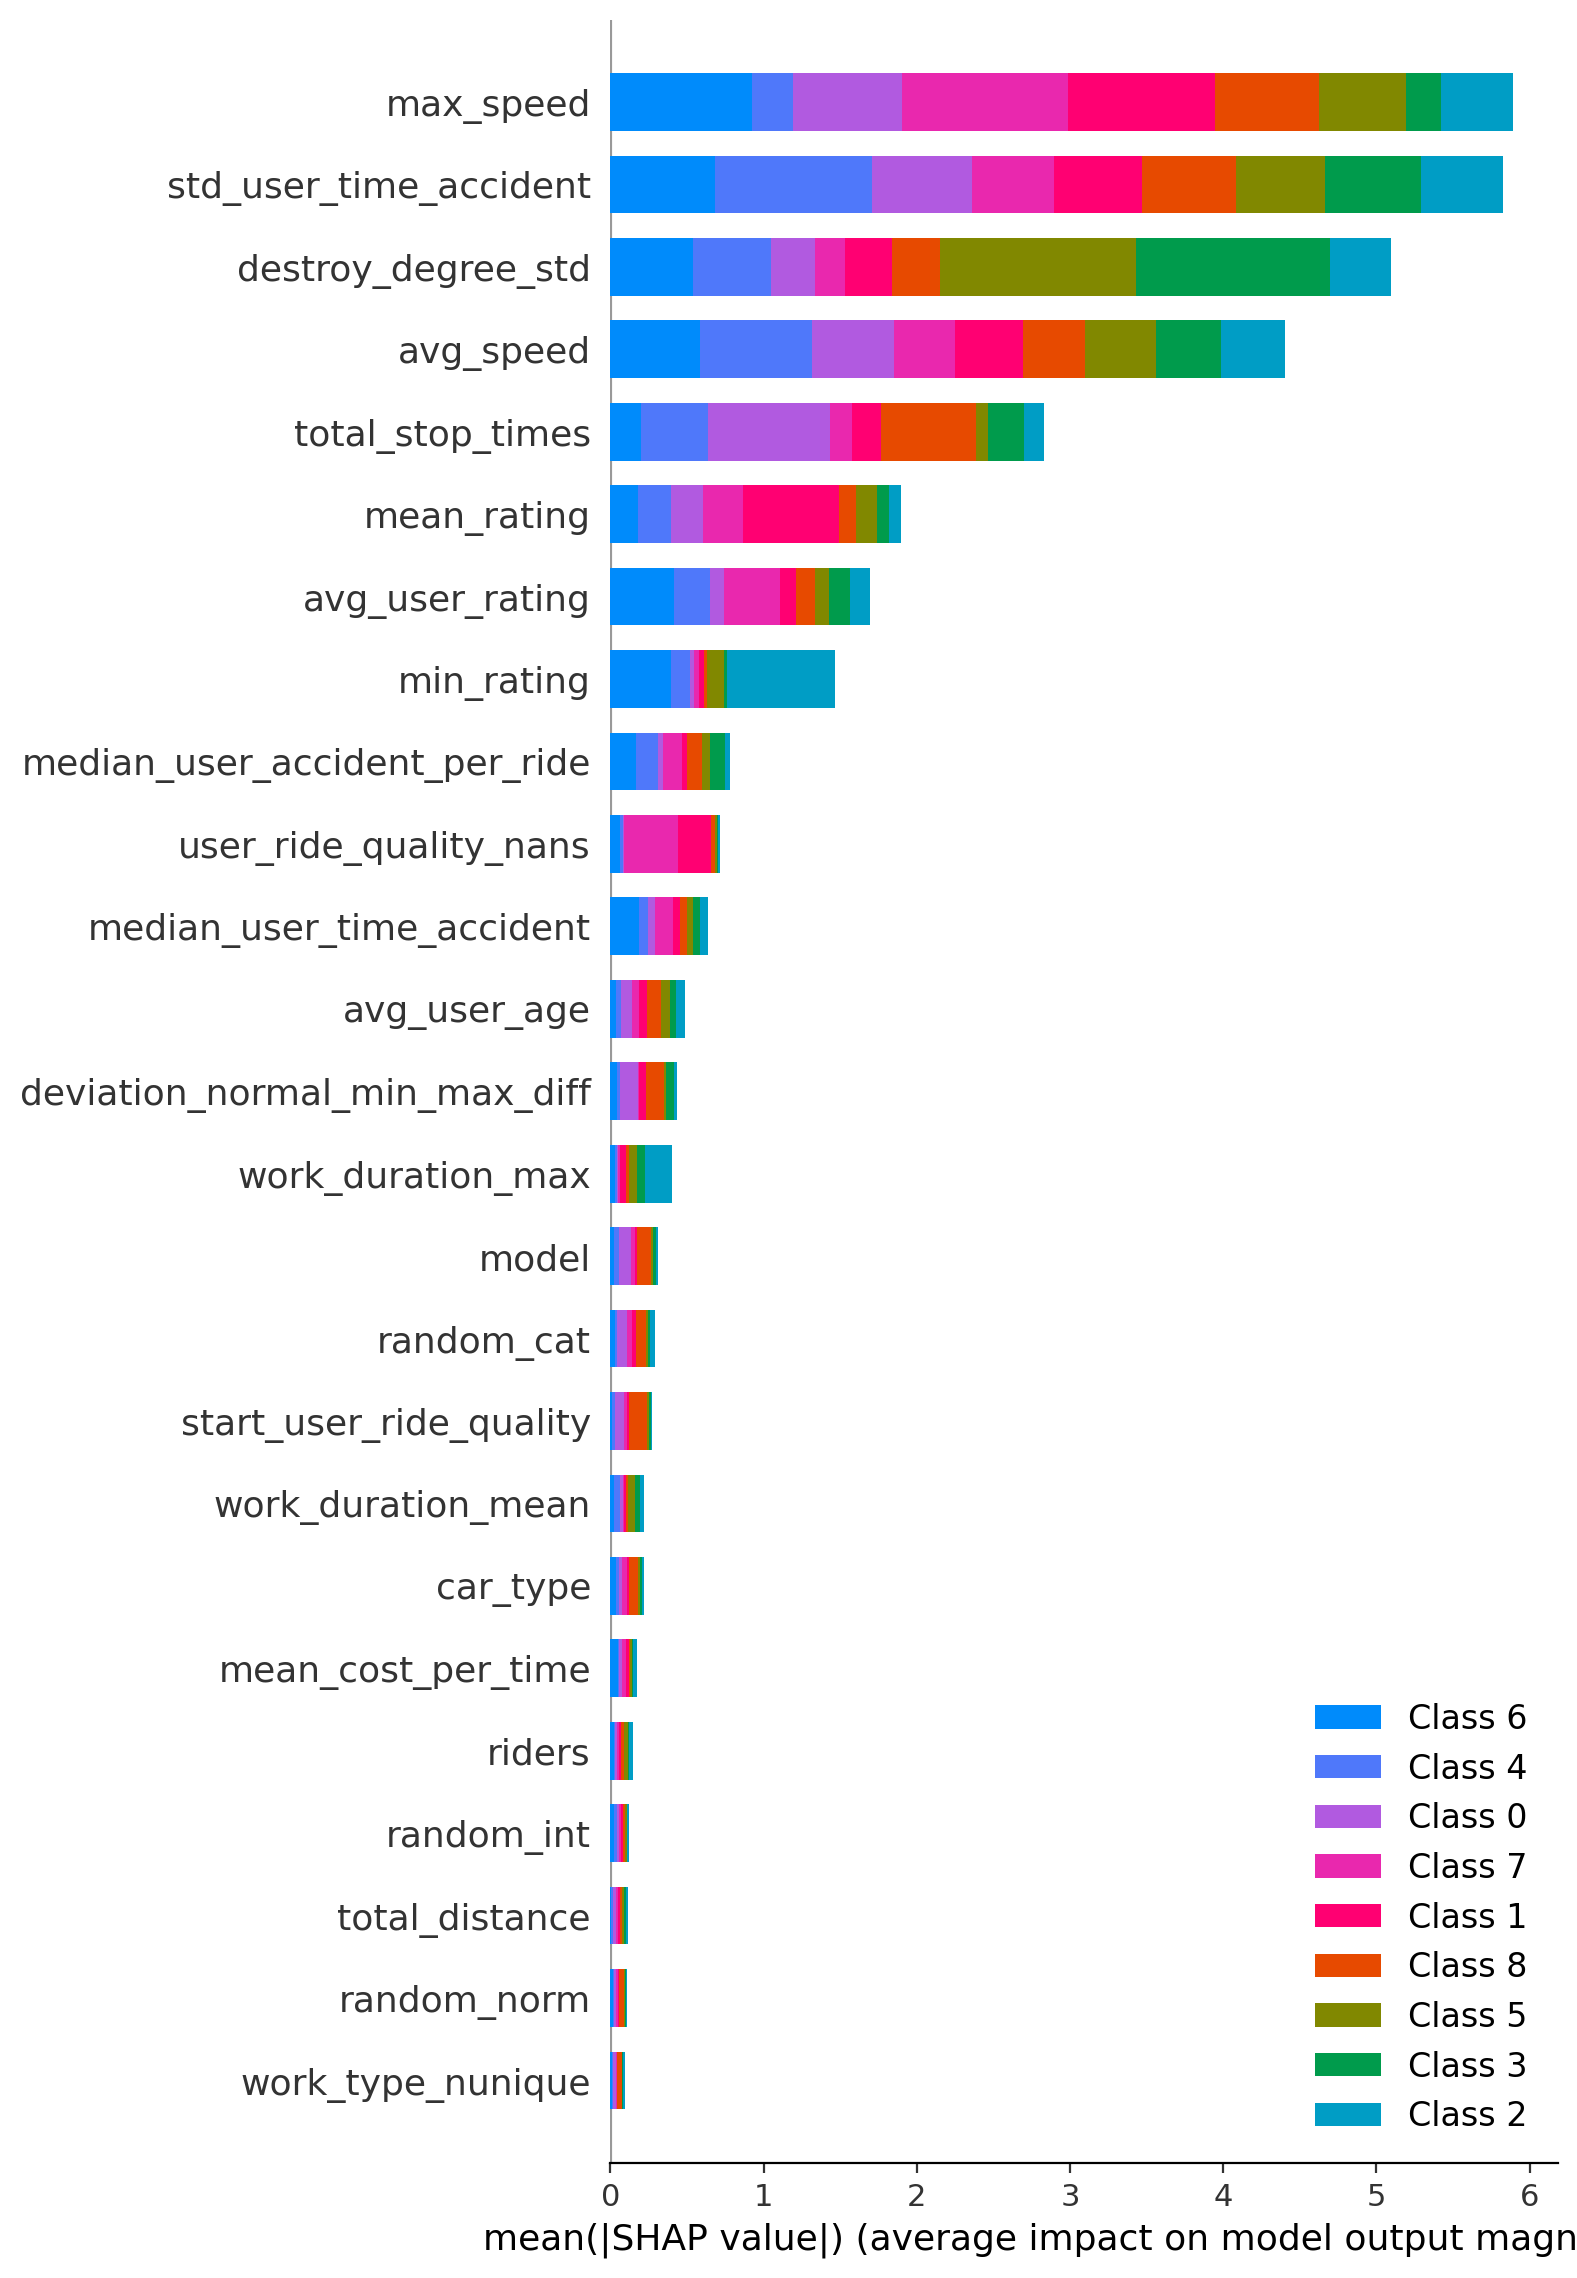

In [58]:
# 5. SHAP values
import shap

explainer = shap.TreeExplainer(model)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25)

In [59]:
# 6. CatBoost Feature Selection
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-32',
                      num_features_to_select=15,
                      steps=3,
                      train_final_model=False,
                      logging_level='Silent')

In [60]:
# Список отобранных признаков (не отранжирован по важности). В него вошел рандомный признак random_norm
print(summary['selected_features_names'])
print()

# Список исключенных признаков
print(summary['eliminated_features_names'])
print()

# Лучшее значение loss
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['car_rating', 'min_rating', 'mean_rating', 'max_speed', 'avg_speed', 'total_stop_times', 'deviation_normal_mean', 'user_ride_quality_nans', 'avg_user_rating', 'median_user_time_accident', 'std_user_time_accident', 'start_user_ride_quality', 'destroy_degree_std', 'work_type_mode', 'random_norm']

['deviation_normal_min_max_diff', 'work_duration_max', 'work_type_nunique', 'random_cat', 'random_ord', 'work_duration_mean', 'riders', 'random_num', 'mean_cost_per_time', 'avg_user_age', 'year_to_start', 'model', 'year_to_work', 'total_distance', 'median_user_accident_per_ride', 'car_type', 'fuel_type', 'random_int']

Best loss: 0.01630728833432797


In [61]:
# Полный отчет работы алгоритма
summary

{'selected_features': [3,
  7,
  8,
  10,
  12,
  13,
  15,
  16,
  18,
  19,
  20,
  22,
  25,
  27,
  30],
 'eliminated_features_names': ['deviation_normal_min_max_diff',
  'work_duration_max',
  'work_type_nunique',
  'random_cat',
  'random_ord',
  'work_duration_mean',
  'riders',
  'random_num',
  'mean_cost_per_time',
  'avg_user_age',
  'year_to_start',
  'model',
  'year_to_work',
  'total_distance',
  'median_user_accident_per_ride',
  'car_type',
  'fuel_type',
  'random_int'],
 'loss_graph': {'main_indices': [0, 8, 13],
  'removed_features_count': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18],
  'loss_values': [0.01919271299141274,
   0.018638596995211604,
   0.018425308959671333,
   0.018320953753446428,
   0.018245845609011505,
   0.018204113658288106,
   0.018171060022120503,
   0.018146829814977658,
   0.018130963759125034,
   0.017517855291226257,
   0.016977932390567052,
   0.016845450306881903

Объединим полученные данные с 6 разных методов и выделим топ-15 признаков для дальнейшей работы. На картинке в столбцах с C по F признаки в порядке убывания значимости 
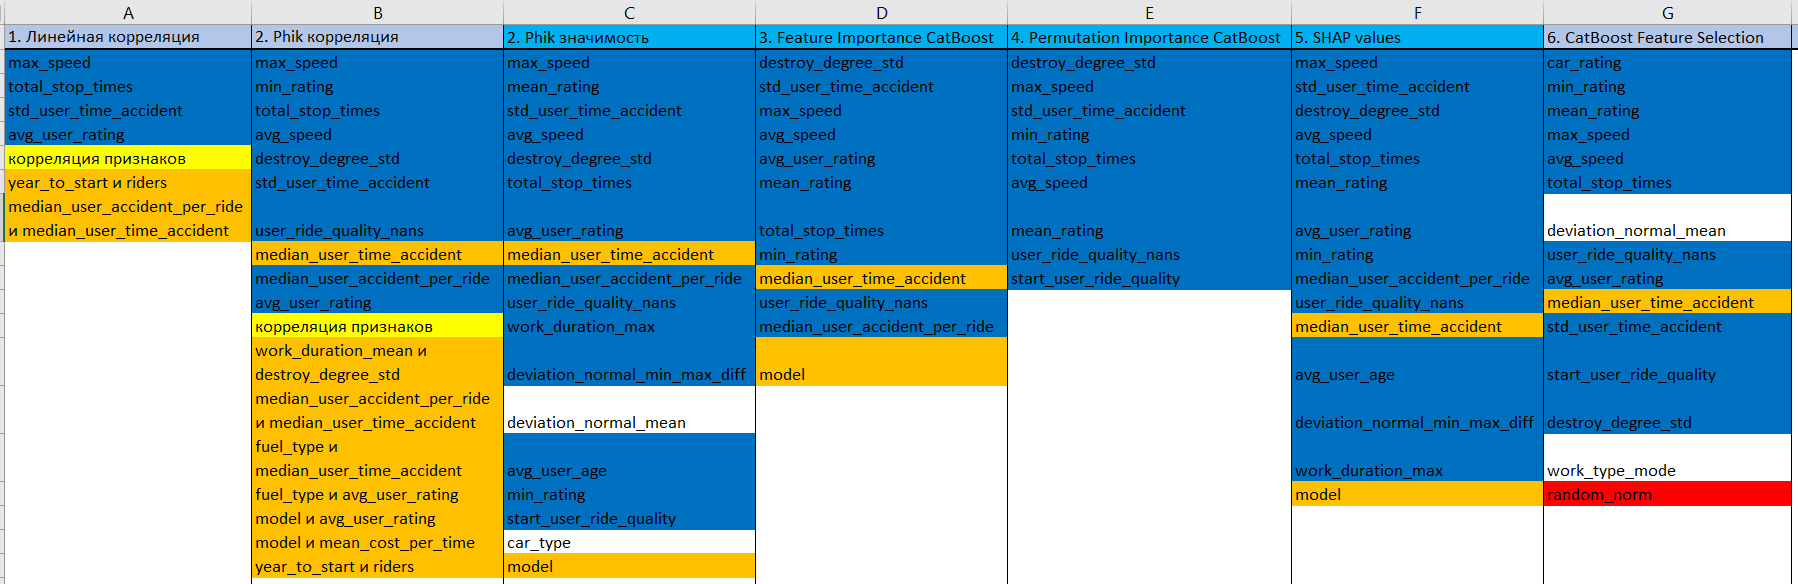
- destroy_degree_std
- max_speed
- std_user_time_accident
- avg_speed
- total_stop_times
- mean_rating
- avg_user_rating
- min_rating
- median_user_accident_per_ride
- user_ride_quality_nans  
---
- start_user_ride_quality
- work_duration_max
- deviation_normal_min_max_diff
- avg_user_age
- car_rating

In [62]:
# Топ-10 самых встречаемых признаков
important_features = ['destroy_degree_std', 'max_speed', 'std_user_time_accident', 'avg_speed', 'total_stop_times', 
                      'mean_rating', 'avg_user_rating', 'min_rating', 'median_user_accident_per_ride', 'user_ride_quality_nans']

In [72]:
# Топ-15 самых встречаемых признаков
important_features_15 = important_features + ['start_user_ride_quality', 'work_duration_max', 'deviation_normal_min_max_diff',
                                             'avg_user_age', 'car_rating']

In [64]:
# Смотрим на изменение loss (было 0.01997779226 при первом применении) при топ-10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_10 = CatBoostClassifier(random_state=42,
                           thread_count=-1)


model_10.fit(X_train[important_features], y_train, 
          eval_set=(X_test[important_features], y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.6516452	test: 1.6510755	best: 1.6510755 (0)	total: 31.8ms	remaining: 31.8s
100:	learn: 0.0209072	test: 0.0262788	best: 0.0262788 (100)	total: 2.6s	remaining: 23.1s
200:	learn: 0.0113243	test: 0.0208351	best: 0.0208351 (200)	total: 5.01s	remaining: 19.9s
300:	learn: 0.0070940	test: 0.0192241	best: 0.0191967 (289)	total: 7.43s	remaining: 17.3s
400:	learn: 0.0052268	test: 0.0187891	best: 0.0187891 (400)	total: 9.82s	remaining: 14.7s
500:	learn: 0.0040463	test: 0.0182458	best: 0.0181969 (499)	total: 12.2s	remaining: 12.2s
600:	learn: 0.0032638	test: 0.0181989	best: 0.0181462 (569)	total: 14.7s	remaining: 9.76s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.01814621296
bestIteration = 569

Shrink model to first 570 iterations.


In [73]:
# Смотрим на изменение loss (было 0.01997779226 при первом применении) при топ-15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model_15 = CatBoostClassifier(random_state=42,
                           thread_count=-1)


model_15.fit(X_train[important_features_15], y_train, 
          eval_set=(X_test[important_features_15], y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.5460743	test: 1.5550485	best: 1.5550485 (0)	total: 70.8ms	remaining: 1m 10s
100:	learn: 0.0183162	test: 0.0257031	best: 0.0257031 (100)	total: 3.43s	remaining: 30.5s
200:	learn: 0.0087355	test: 0.0204935	best: 0.0204935 (200)	total: 7.38s	remaining: 29.3s
300:	learn: 0.0055905	test: 0.0189872	best: 0.0189506 (295)	total: 11.2s	remaining: 26s
400:	learn: 0.0039005	test: 0.0178950	best: 0.0178851 (396)	total: 15s	remaining: 22.4s
500:	learn: 0.0029686	test: 0.0179605	best: 0.0178585 (403)	total: 18.2s	remaining: 18.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.01785852719
bestIteration = 403

Shrink model to first 404 iterations.


CatBoost, loss  
первое применение 0.01997779226  
топ-10 признаков 0.01814621296  
топ-15 признаков 0.01785852719  
наблюдается небольшое уменьшение loss

# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `y` таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.